In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.plotting import figure 
from scipy.stats import gamma
output_notebook()

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Loading BokehJS ...

In [2]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

#### Load Generated Synthetic Data

In [3]:
data = pd.read_csv('observation_higher_background.csv')
data = data.drop(['Unnamed: 0'],axis=1)

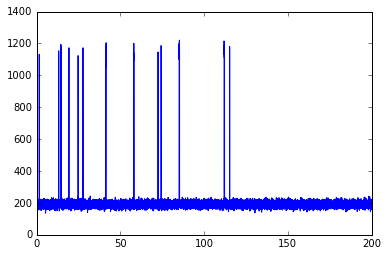

In [4]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [5]:
Wn = np.array(data['1'])
N = len(Wn)  

In [6]:
class FFBS:
    def emission_distribution(self,x,Sn,params,M,ID,Snm):
        # This is needed for the calculation of the Filter
        ind = list(range(M))
        ind.remove(ID)
        self.Ksn = np.where(Sn==1,params['k_sigma2'],0.0) # Ksn[M,N]
        self.Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] # Ksn_filter[8]
        # self.rate [8,N]
        r = params['theta']*hyper_param['dt']*(params['rho']+np.dot(params['bm'][0,ind],self.Ksn[ind,:]))
        self.rate = [r+params['theta']*hyper_param['dt']*self.Ksn_filter[i] for i in range(2)]   
        likelihood = [-self.rate[0]+x*np.log(self.rate[0]),-self.rate[1]+x*np.log(self.rate[1])]
        
        d = []
        d.append(likelihood)
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    def get_filter(self,A,pi0,pi_filter,N,F):
        A[:,0] = np.log(pi0)
        #=============================================================================================
        for i in range(1,2):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1])),(A[2,i-1]+np.log(pi_filter[2,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,2])),(A[2,i-1]+np.log(pi_filter[2,2]))])
            A[2,i] = F[2,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            A[3,i] = F[3,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5])),(A[6,i-1]+np.log(pi_filter[6,5]))])
            A[5,i] = F[5,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,6])),(A[6,i-1]+np.log(pi_filter[6,6]))])
            A[6,i] = F[6,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            A[7,i] = F[7,i]+np.log(np.sum(np.exp(MM)))
        #=============================================================================================
        for i in range(2,N):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1])),(A[2,i-1]+np.log(pi_filter[2,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,2])),(A[2,i-1]+np.log(pi_filter[2,2]))])
            Max = -np.max(MM)
            A[2,i] = F[2,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            Max = -np.max(MM)
            A[3,i] = F[3,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5])),(A[6,i-1]+np.log(pi_filter[6,5]))])
            Max = -np.max(MM)
            A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,6])),(A[6,i-1]+np.log(pi_filter[6,6]))])
            Max = -np.max(MM)
            A[6,i] = F[6,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            Max = -np.max(MM)
            A[7,i] = F[7,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
        
        return A
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        # Likelihood or Emission distribution
        F = self.emission_distribution(Wn,Sn,params,M,ID,Snm)      # F[8,N]
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])   # pi0[8,1] 
#         A_star = pi0*F[:,0]
#         c1 = np.sum(A_star)
#         A[:,0] = A_star[:]/c1  # Array of 8*N where 8 is the number of possible states for the filter 
    
        return self.get_filter(A,pi0,pi_filter,N,F)
    
    def _FFBS(self,N,pi,pi_filter,params):
        # States of the system considered for the filter
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) #Snm[8,2]
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            A = self.Filter(pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param) # A[8,N]
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))        
            
            # Sampling via Gumbel distribution
            g_i = -np.log(-np.log(np.random.uniform(size=8)))
            ind_N = np.argmax(g_i+A[:,N-1])          # Get the state at the last time level
            # Backward Sampling
            Sn[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            AA = A[:4,:] if ind_N<4 else A[4:,:]     # AA[4,N]           
            for n in range(N-2,-1,-1):
                weight = AA[:,n]+np.log(pi[:,Sn[ID,n+1]])
                g_i = -np.log(-np.log(np.random.uniform(size=4)))
                Sn[ID,n] = np.argmax(g_i+weight) 
          
        return bm, Sn

In [31]:
def _proposal_pdf(x1,x2,alfa):
    return ((2*alfa-1)*(np.log(x1/x2))+alfa*(x2/x1-x1/x2))

In [82]:
alfa_proposal = 200
x_old = 4
k_sigma2_prop = np.random.gamma(alfa_proposal,scale=x_old/alfa_proposal, size=10000)

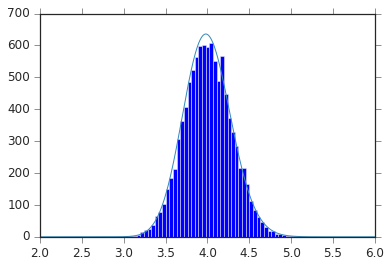

In [90]:
n, bins, patches = plt.hist(k_sigma2_prop, 50, facecolor='blue')
plt.plot(np.linspace(2,6,1000),ss.gamma.pdf(np.linspace(2,6,1000),alfa_proposal,scale=x_old/alfa_proposal)*450)

In [7]:
class Metropolis_Hastings:
    def __init__(self,alfa1,alfa2):
        self.alfa1 = alfa1
        self.alfa2 = alfa2
    
    def sample(self,x,alfa_proposal):
        return np.random.gamma(alfa_proposal,scale=x/alfa_proposal)
    
    def _proposal_pdf(self,x1,x2,alfa):
        return ((2*alfa-1)*(np.log(x1/x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        return (alfa-1)*(np.log(x2/x1))+(x1-x2)/beta
    
    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):
        Ksn1 = np.where(Sn==1,y1,0.0)
        rate1 = (x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] 
        
        Ksn2 = np.where(Sn==1,y2,0.0)
        rate2 = (x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] 
        
        print(np.sum(rate2),np.sum(rate1))
        
        return np.sum(Wn*np.log(rate2/rate1))-(hyper_param['alfa']+np.sum(Wn))*np.log((hyper_param['beta']+np.sum(rate2))/(hyper_param['beta']+np.sum(rate1)))
    
    def Acceptance_ratio(self,Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = (self._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                       self._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))                 
        
        proposal_ratio = (self._proposal_pdf(rho_old,rho_prop,self.alfa1)+
                          self._proposal_pdf(k_sigma2_old,k_sigma2_prop,self.alfa2))              
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
    
        return likelihood_ratio+prior_ratio+proposal_ratio
    
    def Acceptance_ratio_calib_rho(self,Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = self._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2'])                 
        proposal_ratio = self._proposal_pdf(k_sigma2_old,k_sigma2_prop,self.alfa2)    
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
    
        return likelihood_ratio+prior_ratio+proposal_ratio
    
    def Acceptance_ratio_calib_ksigma2(self,Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = self._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])              
        proposal_ratio = self._proposal_pdf(rho_old,rho_prop,self.alfa1)
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
    
        return likelihood_ratio+prior_ratio+proposal_ratio

In [8]:
class Gibbs_sampler:  
    def update_theta(self,alfa,beta,Wn,Ksn,params):
        alfa_new = alfa+np.sum(Wn)
        beta_new = beta+np.sum((params['rho']+np.dot(params['bm'][0,:],Ksn))*hyper_param['dt'])
        
        return np.random.gamma(alfa_new,1./beta_new)
    
    def update_rho_ksigma2(self,Sn,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop = MH.sample(rho_old,hyper_param['alfa1_proposal'])
        k_sigma2_prop = MH.sample(k_sigma2_old,hyper_param['alfa2_proposal'])
        # Step (b)
        AR = MH.Acceptance_ratio(Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
        
    def update_rho(self,Sn,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop = MH.sample(rho_old,hyper_param['alfa1_proposal'])
        k_sigma2_prop = k_sigma2_old
        # Step (b)
        AR = MH.Acceptance_ratio_calib_ksigma2(Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
        
    def update_ksigma2(self,Sn,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop = rho_old
        k_sigma2_prop = MH.sample(k_sigma2_old,hyper_param['alfa2_proposal'])
        # Step (b)
        AR = MH.Acceptance_ratio_calib_rho(Sn,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn,M):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn[j,i]
                if Sn[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return count

    def update_weight_State(self,hyper_param,pi,pi_filter,params):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params)

In [9]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [10]:
def __main__(repeats,M,pi,Sn,Ksn,handle):
    data1 = 'Wn_single3.h5'
    data2 = 'params_single3.h5'
    data3 = 'trajectory_single3.h5'
    
    data = dict({'theta': [],'rho': [],'k_sigma2': [],'B':[], 'ite':[],'E_b':[],'E_ph':[]})

    gibbs = Gibbs_sampler()
    accepted  = 0.0
    accepted_rho = 0.0
    accepted_ksigma2 = 0.0
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        # Metropolis Hastings
        params['rho'], params['k_sigma2'], accepted = gibbs.update_rho_ksigma2(Sn,params,repeats,accepted)
        params['rho'], params['k_sigma2'], accepted_rho = gibbs.update_rho(Sn,params,repeats,accepted_rho)
        params['rho'], params['k_sigma2'], accepted_ksigma2 = gibbs.update_ksigma2(Sn,params,repeats,accepted_ksigma2)  
        # Update theta
        params['theta'] = gibbs.update_theta(hyper_param['alfa'],hyper_param['beta'],Wn,Ksn,params)
        # Update Transition Probabilities
#         count = gibbs.update_pi(Sn,M)

#         state = 0 
#         pi[0] = np.array(list(np.random.dirichlet((0.7+count[state][0],0.3+count[state][1])))+[0,0])
#         state = 1
#         pi[1] = np.array([0]+list(np.random.dirichlet((0.25+count[state][1],0.25+count[state][2],0.2+count[state][3]))))
#         state = 2 
#         pi[2] = np.array([0]+list(np.random.dirichlet((0.4+count[state][1],0.6+count[state][2])))+[0])
#         pi[3] = np.array([0,0,0,1])
        
#         pi_filter = update_pi_filter(pi)
#         p = pd.concat([p,pd.DataFrame(pi)],axis=0)
        
#         # Sanity Check
#         if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
#             pass
#         else:
#             raise Exception('probabilities do not sum to 1')      
        print(params['theta']*params['rho'],params['theta']*params['k_sigma2'])
        
        # FFBS
#         params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params)
        
        # Sanity Check
#         if all(Sn[:,0])==0:
#             pass
#         else:
#             raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['theta'].append(params['theta'])
        data['rho'].append(params['rho'])
        data['k_sigma2'].append(params['k_sigma2'])  
        data['E_b'].append(params['theta']*params['rho'])
        data['E_ph'].append(params['theta']*params['k_sigma2'])
        data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,np.count_nonzero(params['bm']),accepted,accepted_rho,accepted_ksigma2)

        # Save the output
        ## MCMC Chain Parameters
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        ## Emission Distribution
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = params['theta']*(params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']
        estimated_emission_final = pd.DataFrame(dict({'ite':range(N),'est':estimated_emission.reshape(N,)}))
        
        if j%100==0:
            emission_data = pd.HDFStore(data1)
            emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
            emission_data.close()
            ## Trajectory of data
            trajectory_data = pd.HDFStore(data3)
            trajectory_data['df{}'.format(j)] = pd.DataFrame(Sn)
            trajectory_data.close()
            
        # Some postprocessing
#         new_data = dict({'E_b': [params['theta']*params['rho']],'E_ph': [params['theta']*params['k_sigma2']],
#                          'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,handle)
    
    # Calculate Acceptance Rate
    print ("Acceptance rate = " + str(accepted/repeats*100))
    print ("Acceptance rate = " + str(accepted_rho/repeats*100))
    print ("Acceptance rate = " + str(accepted_ksigma2/repeats*100))

    return data, p

#### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [11]:
repeats = 5000

In [12]:
hyper_param = {'alfa':1.0,'beta':1.0,'alfa1_proposal':150000,'beta1':1.0,'alfa1_prior':1.0,'alfa2_prior':1.0,
               'alfa2_proposal':200000,'beta2':1.0,'N_particles':1,'gama':1.0,'dt':0.01*.95} 

In [13]:
M = hyper_param['N_particles']

## Parameters to be calculated by Gibbs Sampler 

In [14]:
# data1 = 'Wn.h5'
# data2 = 'params.h5'
# params_data = pd.HDFStore(data2)
# params = params_data['df{}'.format(15999)] 
# params = dict(params)

In [15]:
# params_data.close()

In [16]:
params = {'theta':1e+3,
          'rho':0.01,
          'k_sigma2':0.01,
          'bm':np.ones((1,M),dtype=int)}  # bm[1,M]

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [17]:
# pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
# pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
# pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
# pi3 = np.array([0,0,0,1])

In [18]:
# pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [19]:
# pi

In [20]:
pi = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
       [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
       [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [21]:
data3 = 'trajectory_higher_background.h5'
trajectory_data = pd.HDFStore(data3)

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expect

In [22]:
Sn = pd.read_csv('trajectory_higher_background.csv').drop('Unnamed: 0',axis=1).values

In [23]:
Sn

array([[0, 0, 0, ..., 3, 3, 3]])

In [24]:
# Sn = np.zeros([M,N],dtype=np.int)
# Sn[:,0] = 0

In [25]:
# # Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# # from state zero to state one and from state one to state zero.
# for i in range(M):
#     for j in range(1,N):
#         Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])  #Sn[M,N] 
# # Sn = pd.DataFrame(Sn)  # This is not efficient from computation point of view

In [26]:
# Sn

In [27]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

In [28]:
def plot_traces(estimated_emission_final,new_data,handle):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    push_notebook(handle=handle)

In [29]:
import time
from line_profiler import LineProfiler
if __name__ == '__main__':
    if os.path.isfile('Wn_single3.h5'):
        os.remove('Wn_single3.h5')
        os.remove('params_single3.h5')
        os.remove('trajectory_single3.h5')
        
    output_notebook()
    source = ColumnDataSource({'E_b':[],'E_ph':[],'B':[],'ite':[]})
    
    s1 = figure(width=250, plot_height=250, title=None)
    s1.scatter(x='ite', y='B', color="navy", alpha=0.5, source=source)

    s2 = figure(width=250, height=250, title=None)
    s2.scatter(x='ite', y='E_b', color="firebrick", alpha=0.5, source=source)

    s3 = figure(width=350, height=250, title=None)
    s3.scatter(x='ite', y='E_ph', color="olive", alpha=0.5, source=source)
    
    source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
    s4 = figure(width=350, height=250, title=None)
    s4.scatter(x='ite', y='est', color="black", alpha=0.5, source=source1)
    s4.scatter(range(N), Wn, color="blue", alpha=0.5)
    
    pl = gridplot([[s1,s2,s3],[s4]], toolbar_location=None)
    handle = show(pl, notebook_handle=True, new='window', notebook_url='localhost:8888')
    
    out = __main__(repeats,M,pi,Sn,Ksn,handle) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS._FFBS)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(repeats,M,pi,Sn,Ksn,pl)
#     lp.print_stats(), format='pdf'
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

Loading BokehJS ...

0
1.9136800000000003 1.9111138407963981
1.9111138407963981 1.914908238745105
1.9111138407963981 1.9111420842340858
13525.230081635274 13602.20386011929
0.016940593719482422 1 1.0 0.0 0.0
1
1.9111138407963981 1.9081744934485263
1.9081744934485263 1.921764697568507
1.9081744934485263 1.9082017286594422
13514.034741718446 13606.595682236923
0.0017108917236328125 1 2.0 0.0 0.0
2
1.9081744934485263 1.9071738853417983
1.9071738853417983 1.906989995126905
1.906989995126905 1.9070061578765332
13517.017804279369 13619.121320350792
0.001543283462524414 1 3.0 1.0 0.0
3
1.906989995126905 1.9144560623533093
1.906989995126905 1.9035713919527735
1.9035713919527735 1.9035707689098584
13506.75666712162 13632.787202016918
0.0015249252319335938 1 3.0 2.0 1.0
4
1.9035707689098584 1.9009366877258458
1.9009366877258458 1.9033158857235977
1.9009366877258458 1.9009236798738436
13487.858441352077 13632.96736441535
0.0014743804931640625 1 4.0 2.0 2.0
5
1.9009236798738436 1.903786926481879
1.9009236798738436 1.9

52
1.7241964923545647 1.7250165503661359
1.7241964923545647 1.7198142153805756
1.7198142153805756 1.719823976163132
13022.091864024784 13883.464480351779
0.002283811569213867 1 27.0 24.0 33.0
53
1.7198142153805756 1.7188882820217306
1.7188882820217306 1.7259593413567715
1.7188882820217306 1.7188853129206971
13029.856162655758 13910.89312120964
0.0015559196472167969 1 28.0 24.0 34.0
54
1.7188853129206971 1.718422333539889
1.718422333539889 1.7184642695212984
1.718422333539889 1.7183974606620211
13017.179455320053 13910.686993287756
0.0015544891357421875 1 29.0 24.0 35.0
55
1.7183974606620211 1.7183992964370864
1.7183992964370864 1.7121550973901583
1.7121550973901583 1.7121061319602542
12997.70180779046 13887.976938314403
0.0015735626220703125 1 30.0 25.0 36.0
56
1.7121061319602542 1.7136180926073943
1.7121061319602542 1.718430940585756
1.7121061319602542 1.7120279725411711
13005.8373466802 13814.14563022467
0.001573324203491211 1 30.0 25.0 37.0
57
1.7120279725411711 1.707866727899586
1.

108
1.5396116742043793 1.5423839129719852
1.5396116742043793 1.5351697665699229
1.5351697665699229 1.535155369956159
12472.624327281157 14095.640226621952
0.0017795562744140625 1 54.0 53.0 61.0
109
1.535155369956159 1.5400446755766115
1.535155369956159 1.532791419903052
1.532791419903052 1.5328109195595467
12458.100476071324 14101.118345836685
0.0017902851104736328 1 54.0 54.0 61.0
110
1.532791419903052 1.5299546026528732
1.5299546026528732 1.5373587055058393
1.5299546026528732 1.5299246887270803
12447.354708146446 14109.048411429023
0.0015180110931396484 1 55.0 54.0 62.0
111
1.5299246887270803 1.5268198591763147
1.5268198591763147 1.527286396846492
1.5268198591763147 1.5268173955180373
12443.31401617963 14169.33272475066
0.0014803409576416016 1 56.0 54.0 63.0
112
1.5268173955180373 1.521419789807196
1.521419789807196 1.5172308289121879
1.5172308289121879 1.5172323686924931
12407.098757900354 14241.63824028392
0.0014803409576416016 1 57.0 55.0 63.0
113
1.5172308289121879 1.514501175681

158
1.3865107234146963 1.3816554588454988
1.3816554588454988 1.3832675801190675
1.3816554588454988 1.3816196192189465
11941.609371518207 14059.509491127788
0.0019168853759765625 1 84.0 75.0 93.0
159
1.3816196192189465 1.3810655421770246
1.3810655421770246 1.3796341195928217
1.3796341195928217 1.379709176350504
11923.01944601281 14116.114330457152
0.0014965534210205078 1 85.0 76.0 93.0
160
1.3796341195928217 1.3768979090908613
1.3768979090908613 1.3712694494160242
1.3712694494160242 1.3712552192228067
11895.328690052893 14093.840847846108
0.001811981201171875 1 86.0 77.0 94.0
161
1.3712552192228067 1.3655751686650244
1.3655751686650244 1.3681936794533862
1.3655751686650244 1.3656223404040615
11880.770994428894 14157.744155523154
0.0013842582702636719 1 87.0 77.0 94.0
162
1.3655751686650244 1.3638752193390324
1.3638752193390324 1.366178544375043
1.3638752193390324 1.3638690920145633
11871.913155345119 14203.75617134516
0.001840353012084961 1 88.0 77.0 95.0
163
1.3638690920145633 1.362108

208
1.263912931841626 1.2616252994979107
1.2616252994979107 1.2596624687834321
1.2596624687834321 1.259650531934992
11464.722516393713 14066.819384561975
0.0018818378448486328 1 111.0 97.0 130.0
209
1.259650531934992 1.2613593909878222
1.259650531934992 1.260001372608272
1.259650531934992 1.2596633911437045
11474.515700745695 14078.835284230026
0.0013725757598876953 1 111.0 97.0 130.0
210
1.259650531934992 1.2614316726506711
1.259650531934992 1.259447910172759
1.259447910172759 1.2594508773865913
11460.379844762338 14063.773436692716
0.001367807388305664 1 111.0 98.0 130.0
211
1.259447910172759 1.2608072100610854
1.259447910172759 1.258144120198235
1.258144120198235 1.2581455568821045
11464.343700465193 14083.34664377822
0.0016644001007080078 1 111.0 99.0 130.0
212
1.258144120198235 1.2599211125055398
1.258144120198235 1.2549558570922894
1.2549558570922894 1.2549900162363554
11434.066853141558 14082.156554846484
0.0017480850219726562 1 111.0 100.0 130.0
213
1.2549558570922894 1.2515821

1.1543387989767129 1.1499634627432254
1.1499634627432254 1.1499530957475357
10993.679229627533 14098.283939040222
0.0020172595977783203 1 132.0 122.0 148.0
254
1.1499530957475357 1.1530061924765067
1.1499530957475357 1.154567523567163
1.1499530957475357 1.1499573164768448
10995.332888304238 14100.404589377154
0.0015456676483154297 1 132.0 122.0 148.0
255
1.1499530957475357 1.1516094537948285
1.1499530957475357 1.1502470443970982
1.1499530957475357 1.1499574564753154
11004.359377540039 14111.980150712077
0.0017426013946533203 1 132.0 122.0 148.0
256
1.1499530957475357 1.1504102218716987
1.1499530957475357 1.1463586866156488
1.1463586866156488 1.1463492578103105
10981.661455753321 14114.866997297999
0.002527475357055664 1 132.0 123.0 149.0
257
1.1463492578103105 1.1503572541950067
1.1463492578103105 1.1471808008213293
1.1463492578103105 1.1463670665238472
10973.613635339963 14104.523032934283
0.0013828277587890625 1 132.0 123.0 149.0
258
1.1463492578103105 1.1481790065298156
1.1463492578

296
1.0768357727407254 1.0742612950061392
1.0742612950061392 1.071905572419635
1.071905572419635 1.0718941566453761
10620.195308031864 14248.341735553611
0.001894235610961914 1 149.0 145.0 161.0
297
1.0718941566453761 1.0765085377016468
1.0718941566453761 1.073617247776615
1.0718941566453761 1.0718491745328778
10626.192933045098 14194.285679262093
0.0018572807312011719 1 149.0 145.0 162.0
298
1.0718491745328778 1.0731229100681596
1.0718491745328778 1.0685986006005557
1.0685986006005557 1.0686002719879593
10611.275030177474 14217.894500933613
0.0014085769653320312 1 149.0 146.0 162.0
299
1.0685986006005557 1.0626254765532206
1.0626254765532206 1.0616918716219486
1.0616918716219486 1.0617154410586649
10584.294465495914 14283.61362172768
0.0014235973358154297 1 150.0 147.0 162.0
300
1.0616918716219486 1.0626813441183598
1.0616918716219486 1.0584585649943614
1.0584585649943614 1.0584307019114143
10565.516334646469 14263.5178355226
0.0015516281127929688 1 150.0 148.0 163.0
301
1.05843070191

352
0.9373305619814052 0.9371171637575852
0.9371171637575852 0.9406668762345767
0.9371171637575852 0.9370822029347341
9936.791330397164 14184.318994492836
0.0018527507781982422 1 174.0 175.0 192.0
353
0.9370822029347341 0.9371318947288487
0.9370822029347341 0.936623120946047
0.936623120946047 0.936651026273191
9936.598580959555 14191.068092841873
0.0015604496002197266 1 174.0 176.0 192.0
354
0.936623120946047 0.9368078843591089
0.936623120946047 0.9404508469723617
0.936623120946047 0.9366135581271507
9931.919839368325 14170.255240209002
0.0018160343170166016 1 174.0 176.0 193.0
355
0.9366135581271507 0.937338300051256
0.9366135581271507 0.9373010289263461
0.9366135581271507 0.9366304172897876
9936.463923850952 14176.738461780793
0.0014481544494628906 1 174.0 176.0 193.0
356
0.9366135581271507 0.9352513910313626
0.9352513910313626 0.9348572528320274
0.9348572528320274 0.9348688399229638
9929.056619004434 14189.353419826548
0.001615762710571289 1 175.0 177.0 193.0
357
0.9348572528320274 

0.8671307502868966 0.865930898513581
0.865930898513581 0.8652318493238567
0.8652318493238567 0.8652798120255538
9525.581080213356 14009.959804686834
0.0019483566284179688 1 194.0 204.0 219.0
408
0.8652318493238567 0.8600426267254776
0.8600426267254776 0.8581825309351698
0.8581825309351698 0.8581903505083592
9484.171231629218 13996.227213012711
0.0013575553894042969 1 195.0 205.0 219.0
409
0.8581825309351698 0.8591907737627356
0.8581825309351698 0.856805796178576
0.856805796178576 0.8568146155923272
9482.023345325177 14015.78280333142
0.0016484260559082031 1 195.0 206.0 219.0
410
0.856805796178576 0.8582699329448686
0.856805796178576 0.8547653027493791
0.8547653027493791 0.8547536182688878
9467.969584489443 14010.734446233013
0.001573324203491211 1 195.0 207.0 220.0
411
0.8547536182688878 0.855522363308262
0.8547536182688878 0.8544246069407981
0.8544246069407981 0.8544387940529188
9458.486853314364 14002.14939445421
0.0016033649444580078 1 195.0 208.0 220.0
412
0.8544246069407981 0.8512

462
0.7660581818262877 0.7669151014311915
0.7660581818262877 0.7686475097293404
0.7660581818262877 0.7660165101612555
8904.099362715979 13917.743127007085
0.0021529197692871094 1 224.0 237.0 252.0
463
0.7660165101612555 0.7635962715747115
0.7635962715747115 0.7659708846870463
0.7635962715747115 0.7635894110010035
8881.45766846152 13952.26523377189
0.0016205310821533203 1 225.0 237.0 253.0
464
0.7635894110010035 0.75981939699217
0.75981939699217 0.7623155702617271
0.75981939699217 0.75980720877737
8859.14709218941 13974.562961529446
0.0015482902526855469 1 226.0 237.0 254.0
465
0.75980720877737 0.756513790497471
0.756513790497471 0.7567394598382451
0.756513790497471 0.7564893921478177
8832.400367867356 13975.689847399939
0.0014269351959228516 1 227.0 237.0 255.0
466
0.7564893921478177 0.7561776362143222
0.7561776362143222 0.7572509060154073
0.7561776362143222 0.756184106574608
8837.4209071214 14005.904965348438
0.0013892650604248047 1 228.0 237.0 255.0
467
0.7561776362143222 0.753028122

510
0.688568169093018 0.6902905220132864
0.688568169093018 0.6899263016102508
0.688568169093018 0.688548281469173
8357.784616290393 13688.69484862833
0.0017046928405761719 1 246.0 264.0 280.0
511
0.688548281469173 0.6913195756099833
0.688548281469173 0.6916769527214803
0.688548281469173 0.6885437311180118
8359.817965032664 13684.314787641279
0.0016260147094726562 1 246.0 264.0 281.0
512
0.6885437311180118 0.6889428114435883
0.6885437311180118 0.687407683807016
0.687407683807016 0.6873798740484298
8341.503453318257 13630.071918867094
0.001477956771850586 1 246.0 265.0 282.0
513
0.6873798740484298 0.6896945051576986
0.6873798740484298 0.6881480019707371
0.6873798740484298 0.6873772117832967
8353.521705859288 13645.194599327082
0.0014641284942626953 1 246.0 265.0 283.0
514
0.6873772117832967 0.6883193818977981
0.6873772117832967 0.6871901467677467
0.6871901467677467 0.6872046263267823
8345.896946245308 13636.494843013605
0.0014328956604003906 1 246.0 266.0 283.0
515
0.6871901467677467 0.6

558
0.6233497877021565 0.6226202951725052
0.6226202951725052 0.6229092993833379
0.6226202951725052 0.6226294463043621
7859.245464575234 13398.526947088245
0.0019762516021728516 1 271.0 283.0 305.0
559
0.6226202951725052 0.6200468241658603
0.6200468241658603 0.621089976072478
0.6200468241658603 0.620045895131081
7847.69456549888 13406.747557017385
0.0016329288482666016 1 272.0 283.0 306.0
560
0.620045895131081 0.6207362186164861
0.620045895131081 0.6163374707109113
0.6163374707109113 0.6163651735159785
7811.378659870567 13426.000642058854
0.0015230178833007812 1 272.0 284.0 306.0
561
0.6163374707109113 0.6162252474343817
0.6162252474343817 0.6118503034394831
0.6118503034394831 0.6118316874820924
7777.626119982981 13481.490902074273
0.0015742778778076172 1 273.0 285.0 307.0
562
0.6118316874820924 0.6109822701690537
0.6109822701690537 0.6088973699743898
0.6088973699743898 0.6089003240412487
7758.523867504984 13535.213092080301
0.0013892650604248047 1 274.0 286.0 307.0
563
0.60889736997438

600
0.5563616784182286 0.5575208552340774
0.5563616784182286 0.5590537466477561
0.5563616784182286 0.5563744808618984
7321.838390194997 13545.841197956459
0.0017576217651367188 1 294.0 303.0 329.0
601
0.5563616784182286 0.5551057157592225
0.5551057157592225 0.5539416110713491
0.5539416110713491 0.5539529128916383
7300.876992406864 13551.12528318827
0.0016584396362304688 1 295.0 304.0 329.0
602
0.5539416110713491 0.5545965122238051
0.5539416110713491 0.5532216258881287
0.5532216258881287 0.5532495101984535
7292.82284073176 13554.029924352439
0.0018846988677978516 1 295.0 305.0 329.0
603
0.5532216258881287 0.555871841812042
0.5532216258881287 0.554957120242994
0.5532216258881287 0.553235997564448
7291.605189752872 13551.766866800419
0.0015492439270019531 1 295.0 305.0 329.0
604
0.5532216258881287 0.5524808638741421
0.5524808638741421 0.5511371309150281
0.5511371309150281 0.551127471857362
7275.060882214235 13593.448114072537
0.0015773773193359375 1 296.0 306.0 330.0
605
0.551127471857362

651
0.5054569943274501 0.5052065977792162
0.5052065977792162 0.5021014124318159
0.5021014124318159 0.5020804595434771
6836.014153903133 13487.320277322739
0.002062559127807617 1 320.0 328.0 354.0
652
0.5020804595434771 0.5039606496664455
0.5020804595434771 0.5020166586132336
0.5020166586132336 0.5019999213582738
6835.094778612781 13455.364612268935
0.0016334056854248047 1 320.0 329.0 355.0
653
0.5019999213582738 0.5003696289057837
0.5003696289057837 0.5005403540722311
0.5003696289057837 0.5003791063869898
6824.159104785688 13446.807048565868
0.001554727554321289 1 321.0 329.0 355.0
654
0.5003696289057837 0.5005540323427023
0.5003696289057837 0.49928200608070844
0.49928200608070844 0.49926325373993646
6806.630347025694 13406.137570318284
0.0016589164733886719 1 321.0 330.0 356.0
655
0.49926325373993646 0.4964523396679889
0.4964523396679889 0.4949886760095048
0.4949886760095048 0.4949937813877223
6773.7558066293695 13433.113002695136
0.002713441848754883 1 322.0 331.0 356.0
656
0.4949886

701
0.45181725336016343 0.45232940265482324
0.45181725336016343 0.4502355840871158
0.4502355840871158 0.45022052241126004
6342.778562061729 13317.1655517686
0.0019154548645019531 1 339.0 356.0 379.0
702
0.45022052241126004 0.44813244332442925
0.44813244332442925 0.44769673922462927
0.44769673922462927 0.4476855765829315
6318.033631889781 13314.7893958635
0.0015597343444824219 1 340.0 357.0 380.0
703
0.4476855765829315 0.44736429231488073
0.44736429231488073 0.44771726521258354
0.44736429231488073 0.4473893044721632
6320.86067335103 13303.691087104924
0.0015392303466796875 1 341.0 357.0 380.0
704
0.44736429231488073 0.44644001560200725
0.44644001560200725 0.446362237491731
0.446362237491731 0.4463724831728416
6308.370559712633 13282.229926516353
0.0010831356048583984 1 342.0 358.0 380.0
705
0.446362237491731 0.4473361375530155
0.446362237491731 0.44644398909022937
0.446362237491731 0.4463579480769061
6306.378386280616 13269.549271925824
0.0015032291412353516 1 342.0 358.0 381.0
706
0.44

753
0.40663726302019493 0.40708309620433814
0.40663726302019493 0.40618149472401943
0.40618149472401943 0.4061835211410285
5898.796977141759 13312.637189249876
0.001712799072265625 1 363.0 384.0 403.0
754
0.40618149472401943 0.4054804208112115
0.4054804208112115 0.4052349766399186
0.4052349766399186 0.40523867127726176
5888.234187622301 13340.952919430862
0.0017256736755371094 1 364.0 385.0 403.0
755
0.4052349766399186 0.4071513404200987
0.4052349766399186 0.4060511459654299
0.4052349766399186 0.4052636261535273
5892.387961552966 13350.364111425137
0.0014765262603759766 1 364.0 385.0 403.0
756
0.4052349766399186 0.4064185436187394
0.4052349766399186 0.4046521037476879
0.4046521037476879 0.40465426442550323
5882.125648660747 13346.625400679215
0.0015339851379394531 1 364.0 386.0 403.0
757
0.4046521037476879 0.40586280146327564
0.4046521037476879 0.40313819898496805
0.40313819898496805 0.40314055409914307
5861.2499904900305 13350.025693263959
0.0015745162963867188 1 364.0 387.0 403.0
758

795
0.3800336012089576 0.3801616721104132
0.3800336012089576 0.3811339571688409
0.3800336012089576 0.38002946364631823
5619.8849844932 13230.610711796502
0.0010716915130615234 1 383.0 401.0 419.0
796
0.38002946364631823 0.3786034193937496
0.3786034193937496 0.37810118223543754
0.37810118223543754 0.37811414370278307
5595.383688035356 13238.718193036239
0.0010879039764404297 1 384.0 402.0 419.0
797
0.37810118223543754 0.3791664189243268
0.37810118223543754 0.37831335325405085
0.37810118223543754 0.3780928226839315
5596.623871534262 13224.293335265074
0.0020461082458496094 1 384.0 402.0 420.0
798
0.3780928226839315 0.37742157976274116
0.37742157976274116 0.3773379117686475
0.3773379117686475 0.37732258294082266
5585.826320827377 13186.890458388028
0.001481771469116211 1 385.0 403.0 421.0
799
0.37732258294082266 0.3766926291040448
0.3766926291040448 0.37649361970824985
0.37649361970824985 0.37650174529226416
5580.647088136591 13219.664655292194
0.0016224384307861328 1 386.0 404.0 421.0
80

848
0.34195900317658456 0.34260377256030783
0.34195900317658456 0.34220460794355767
0.34195900317658456 0.3419464919131753
5194.837213438406 13005.276115940169
0.0019953250885009766 1 410.0 428.0 455.0
849
0.3419464919131753 0.34246905013782764
0.3419464919131753 0.34153892381524836
0.34153892381524836 0.34153979485805697
5188.260798843492 13004.593664132653
0.0018475055694580078 1 410.0 429.0 455.0
850
0.34153892381524836 0.34232253455877704
0.34153892381524836 0.3418808511104221
0.34153892381524836 0.34152601897516094
5190.459961182004 12982.564921392368
0.001811981201171875 1 410.0 429.0 456.0
851
0.34152601897516094 0.34130389545666234
0.34130389545666234 0.3395150947309989
0.3395150947309989 0.3395354337911519
5163.871580358442 13018.364105163117
0.0013964176177978516 1 411.0 430.0 456.0
852
0.3395150947309989 0.3401800356625339
0.3395150947309989 0.33881768764675774
0.33881768764675774 0.3388123168064532
5153.488134447113 13007.945694184762
0.0014526844024658203 1 411.0 431.0 457

892
0.31575685571737927 0.3150896650947396
0.3150896650947396 0.3142311090846334
0.3142311090846334 0.31425289409022844
4867.906196636987 12454.59299207041
0.001341104507446289 1 433.0 451.0 483.0
893
0.3142311090846334 0.3155376889223836
0.3142311090846334 0.31496024359137154
0.3142311090846334 0.3142422793239763
4872.906259402451 12467.385709136664
0.0015773773193359375 1 433.0 451.0 483.0
894
0.3142311090846334 0.31449808996072537
0.3142311090846334 0.31469871818386186
0.3142311090846334 0.31424609656353164
4871.26355856942 12463.18284049937
0.0014290809631347656 1 433.0 451.0 483.0
895
0.3142311090846334 0.3134143090363694
0.3134143090363694 0.31401292671791753
0.3134143090363694 0.31341493498763373
4858.79663102604 12480.38568199908
0.0014162063598632812 1 434.0 451.0 483.0
896
0.3134143090363694 0.3128660933888255
0.3128660933888255 0.3116360626354182
0.3116360626354182 0.3116280616439354
4840.179794004131 12474.954653309202
0.0014328956604003906 1 435.0 452.0 484.0
897
0.3116280

938
0.28804056250468985 0.2890926753269091
0.28804056250468985 0.2874969824428796
0.2874969824428796 0.28750469249422755
4541.992919776742 12082.714740368867
0.0016472339630126953 1 456.0 474.0 506.0
939
0.2874969824428796 0.286129235729889
0.286129235729889 0.2873079805740838
0.286129235729889 0.2861392003509394
4527.617185647966 12038.25632618894
0.0018527507781982422 1 457.0 474.0 506.0
940
0.286129235729889 0.2861757802879125
0.286129235729889 0.28656509937357805
0.286129235729889 0.28610772971311765
4528.186660089609 11991.923459823915
0.0015978813171386719 1 457.0 474.0 507.0
941
0.28610772971311765 0.287085022149018
0.28610772971311765 0.28676609338500875
0.28610772971311765 0.2860960635533339
4533.60195194168 11980.278545495905
0.0015821456909179688 1 457.0 474.0 508.0
942
0.2860960635533339 0.28544966648836817
0.28544966648836817 0.28534716753923206
0.28534716753923206 0.2853501228863377
4520.65908710963 11947.516047772677
0.0013766288757324219 1 458.0 475.0 508.0
943
0.285347

981
0.2663311053464198 0.26673869337201556
0.2663311053464198 0.26648507020226736
0.2663311053464198 0.2663428527679167
4280.817295741982 11695.812499964715
0.0014934539794921875 1 475.0 494.0 532.0
982
0.2663311053464198 0.26653866837645457
0.2663311053464198 0.26576789526812705
0.26576789526812705 0.26577297884377765
4269.72494496195 11690.718667166973
0.001383066177368164 1 475.0 495.0 532.0
983
0.26576789526812705 0.2653776809922333
0.2653776809922333 0.2655453368313959
0.2653776809922333 0.26537870052308477
4270.275158393379 11708.282579054574
0.0015997886657714844 1 476.0 495.0 532.0
984
0.2653776809922333 0.2655947991618068
0.2653776809922333 0.2656841883174722
0.2653776809922333 0.2653766053271985
4268.720486861014 11701.586084234728
0.001636505126953125 1 476.0 495.0 533.0
985
0.2653766053271985 0.26575221150115474
0.2653766053271985 0.26483287449260184
0.26483287449260184 0.2648345597026017
4257.969964271054 11696.557739313961
0.0013828277587890625 1 476.0 496.0 533.0
986
0.2

1024
0.24266472453961918 0.24242411157946891
0.24242411157946891 0.24229343844037754
0.24229343844037754 0.24230342419742873
3966.6898859823195 11332.348940548607
0.0021927356719970703 1 498.0 517.0 560.0
1025
0.24229343844037754 0.2422251322616667
0.2422251322616667 0.24157682480813164
0.24157682480813164 0.2415708786026527
3955.553121472084 11297.763714394412
0.001514434814453125 1 499.0 518.0 561.0
1026
0.2415708786026527 0.24151580202605813
0.24151580202605813 0.24066115065483498
0.24066115065483498 0.24065123011931897
3942.908487060197 11288.695659259307
0.0015230178833007812 1 500.0 519.0 562.0
1027
0.24065123011931897 0.24031715619898658
0.24031715619898658 0.23996986496466713
0.23996986496466713 0.23996599005671884
3930.7149754398265 11256.544898662818
0.0015654563903808594 1 501.0 520.0 563.0
1028
0.23996599005671884 0.239825154671982
0.239825154671982 0.23972233449820007
0.23972233449820007 0.23972877649750185
3927.5599009293637 11246.062386764714
0.0016472339630126953 1 502.

1074
0.220203576630901 0.22052204428679262
0.220203576630901 0.2198794686022377
0.2198794686022377 0.21988754058804
3660.430557033906 11132.653827326938
0.001695394515991211 1 522.0 544.0 583.0
1075
0.2198794686022377 0.22084288085642
0.2198794686022377 0.2198463509078064
0.2198463509078064 0.21982882390969816
3656.6728629371464 11081.842645422443
0.0014653205871582031 1 522.0 545.0 584.0
1076
0.21982882390969816 0.21929430468983885
0.21929430468983885 0.21941535183887223
0.21929430468983885 0.21929967126127353
3651.8506142859064 11058.730367666603
0.0014057159423828125 1 523.0 545.0 584.0
1077
0.21929430468983885 0.21929982934934383
0.21929430468983885 0.21903701355656865
0.21903701355656865 0.21904270158466738
3647.790937843265 11059.69753378445
0.001268148422241211 1 523.0 546.0 584.0
1078
0.21903701355656865 0.21979513064088657
0.21903701355656865 0.21949011861832135
0.21903701355656865 0.21902893234416826
3651.173124853793 11050.9641304427
0.0013840198516845703 1 523.0 546.0 585.0

1123
0.20767094376804335 0.20742644409908623
0.20742644409908623 0.20767641026686687
0.20742644409908623 0.2074176051182192
3486.9596018934226 10755.68463618002
0.002009868621826172 1 542.0 563.0 605.0
1124
0.2074176051182192 0.20755518518814506
0.2074176051182192 0.2085841550337731
0.2074176051182192 0.20742062427356678
3487.740637810757 10758.09377679978
0.001613616943359375 1 542.0 563.0 605.0
1125
0.2074176051182192 0.20748902475370984
0.2074176051182192 0.20602373226734527
0.20602373226734527 0.2060547573535239
3467.216663610488 10768.772612605011
0.0016169548034667969 1 542.0 564.0 605.0
1126
0.20602373226734527 0.20562115466110178
0.20562115466110178 0.2069555365385057
0.20562115466110178 0.2056391348678068
3458.5923607828995 10774.891171775418
0.0015790462493896484 1 543.0 564.0 605.0
1127
0.20562115466110178 0.20625527660532136
0.20562115466110178 0.20518214971453613
0.20518214971453613 0.20519580653276168
3456.2412309948636 10791.12612503356
0.0015230178833007812 1 543.0 565.

1170
0.18991294764282635 0.19073464156402647
0.18991294764282635 0.18980063822570767
0.18980063822570767 0.18980433530845134
3234.406982858744 10579.698152053426
0.0021736621856689453 1 563.0 587.0 628.0
1171
0.18980063822570767 0.18914577510363578
0.18914577510363578 0.18999652115589666
0.18914577510363578 0.18915077208159914
3223.6166495577027 10537.634928228412
0.0015223026275634766 1 564.0 587.0 628.0
1172
0.18914577510363578 0.18932339858397607
0.18914577510363578 0.1891461827483336
0.18914577510363578 0.1891400051427824
3223.670266836525 10523.925382734322
0.0016415119171142578 1 564.0 587.0 629.0
1173
0.1891400051427824 0.19007407315352215
0.1891400051427824 0.18972320338156487
0.1891400051427824 0.18913674374224176
3223.341531209816 10515.00477650977
0.0015807151794433594 1 564.0 587.0 630.0
1174
0.18913674374224176 0.18870981202784892
0.18870981202784892 0.1890196984952229
0.18870981202784892 0.18871190593721923
3216.7971597464434 10514.77424964019
0.0015521049499511719 1 565.

1218
0.17447123007593085 0.17515882973473534
0.17447123007593085 0.1748976815483284
0.17447123007593085 0.1744762845709471
3009.030494480476 10245.50008323944
0.00177764892578125 1 586.0 610.0 652.0
1219
0.17447123007593085 0.17436545356705915
0.17436545356705915 0.17413612327195505
0.17413612327195505 0.17413215687797257
3005.621082649146 10278.766031426943
0.0014109611511230469 1 587.0 611.0 653.0
1220
0.17413215687797257 0.17458604040717682
0.17413215687797257 0.1744252695295246
0.17413215687797257 0.17412742946347393
3003.249778088291 10259.13225949104
0.0013828277587890625 1 587.0 611.0 654.0
1221
0.17412742946347393 0.1740768491320294
0.1740768491320294 0.1736713399287557
0.1736713399287557 0.1736747412298961
2998.283484100077 10298.779022363777
0.0013880729675292969 1 588.0 612.0 654.0
1222
0.1736713399287557 0.17373453088610336
0.1736713399287557 0.173297461454207
0.173297461454207 0.17330439069823844
2989.7962319497647 10292.33530893303
0.0013785362243652344 1 588.0 613.0 654.

0.1574672298085854 0.15766605035958875
0.1574672298085854 0.15747080343933068
2749.402531685832 9932.773180410712
0.002282857894897461 1 609.0 637.0 680.0
1265
0.1574672298085854 0.15816187819337718
0.1574672298085854 0.15643492518593677
0.15643492518593677 0.15643588339146391
2733.288033800461 9941.436259593607
0.0017163753509521484 1 609.0 638.0 680.0
1266
0.15643492518593677 0.15628221169306628
0.15628221169306628 0.156270849915302
0.156270849915302 0.15626983248865078
2733.5505347163867 9943.41109290373
0.001547098159790039 1 610.0 639.0 681.0
1267
0.15626983248865078 0.15659531998284237
0.15626983248865078 0.156486009441653
0.15626983248865078 0.15627952898515332
2733.2673456113184 9942.380979996373
0.0015265941619873047 1 610.0 639.0 681.0
1268
0.15626983248865078 0.1567856166073725
0.15626983248865078 0.1569838532076528
0.15626983248865078 0.15625473613553162
2731.0318852424134 9896.901218968509
0.0015811920166015625 1 610.0 639.0 682.0
1269
0.15625473613553162 0.156448396270832

1306
0.1463238035846729 0.14649085407055853
0.1463238035846729 0.14676719984176143
0.1463238035846729 0.14632828468436154
2577.052545593186 9727.62771703629
0.0028390884399414062 1 628.0 659.0 701.0
1307
0.1463238035846729 0.14623396491745655
0.14623396491745655 0.14629903121211463
0.14623396491745655 0.14624028917116247
2578.183078758306 9698.274992280974
0.0017058849334716797 1 629.0 659.0 701.0
1308
0.14623396491745655 0.1462715500934498
0.14623396491745655 0.14620409689309413
0.14620409689309413 0.14621626413418976
2575.7407061388935 9691.120970457223
0.001844167709350586 1 629.0 660.0 701.0
1309
0.14620409689309413 0.14637876998766527
0.14620409689309413 0.14635990209623506
0.14620409689309413 0.14619890884752995
2577.8460623315605 9686.08154284736
0.0018815994262695312 1 629.0 660.0 702.0
1310
0.14619890884752995 0.14597420649084022
0.14597420649084022 0.14552694252553272
0.14552694252553272 0.14551872644100466
2567.475785738206 9658.331630670482
0.0014503002166748047 1 630.0 661

1355
0.13113203336778517 0.1307266620304243
0.1307266620304243 0.1307307443505006
0.1307266620304243 0.13073165082811822
2330.460631717848 9206.377928580838
0.0016553401947021484 1 649.0 688.0 725.0
1356
0.1307266620304243 0.13003308406996264
0.13003308406996264 0.1298505708419954
0.1298505708419954 0.12985501678247985
2317.6694641929844 9209.912604331817
0.0015864372253417969 1 650.0 689.0 725.0
1357
0.1298505708419954 0.1295785038189833
0.1295785038189833 0.12986426613505428
0.1295785038189833 0.12957974739176586
2312.6350936087297 9196.270182601482
0.0016582012176513672 1 651.0 689.0 725.0
1358
0.1295785038189833 0.12934842272206257
0.12934842272206257 0.1293328365843793
0.1293328365843793 0.12933560209207617
2310.919713292667 9174.401366444408
0.0015370845794677734 1 652.0 690.0 725.0
1359
0.1293328365843793 0.12929669074206815
0.12929669074206815 0.12894343371681405
0.12894343371681405 0.1289596929667961
2304.565950621886 9185.355404330683
0.0013790130615234375 1 653.0 691.0 725.0

1399
0.12001979618380351 0.1200778764196895
0.12001979618380351 0.12012948361360598
0.12001979618380351 0.12002170049145491
2160.921146458139 8954.136191814001
0.0017783641815185547 1 671.0 714.0 750.0
1400
0.12001979618380351 0.11982588919039427
0.11982588919039427 0.11979740313558555
0.11979740313558555 0.11978003558260343
2154.21645950299 8902.313753430124
0.0015082359313964844 1 672.0 715.0 751.0
1401
0.11978003558260343 0.11969794236782395
0.11969794236782395 0.11973407160041712
0.11969794236782395 0.11969899831253382
2153.596573225085 8906.171973173598
0.0017223358154296875 1 673.0 715.0 751.0
1402
0.11969794236782395 0.11961189134551996
0.11961189134551996 0.11898216659986062
0.11898216659986062 0.11898250980207117
2140.103265254468 8902.27391488691
0.0014979839324951172 1 674.0 716.0 751.0
1403
0.11898216659986062 0.11872299619159524
0.11872299619159524 0.11852954019355486
0.11852954019355486 0.11853612559173297
2134.7641532112702 8880.365177363321
0.0014405250549316406 1 675.0

1448
0.10611309573822938 0.10670443351463484
0.10611309573822938 0.10642407225508325
0.10611309573822938 0.10612855166783802
1927.4849964178584 8689.148820231772
0.0016443729400634766 1 694.0 744.0 770.0
1449
0.10611309573822938 0.10600822864429157
0.10600822864429157 0.1056271724375304
0.1056271724375304 0.1056260283176385
1918.8037816862998 8703.02234851183
0.001499176025390625 1 695.0 745.0 771.0
1450
0.1056260283176385 0.10566279528226433
0.1056260283176385 0.1054686903106532
0.1054686903106532 0.1054599759096364
1916.9958023717124 8685.654417842192
0.0014357566833496094 1 695.0 746.0 772.0
1451
0.1054599759096364 0.10573555570129994
0.1054599759096364 0.10552750992751586
0.1054599759096364 0.10546902577921011
1916.4996142084174 8683.406254905543
0.0015172958374023438 1 695.0 746.0 772.0
1452
0.1054599759096364 0.10547925814775647
0.1054599759096364 0.10569213729950655
0.1054599759096364 0.10546074404571945
1916.8933383854392 8685.19016707339
0.0013697147369384766 1 695.0 746.0 772

1494
0.09710297997363283 0.09734082548277721
0.09710297997363283 0.09712669423373907
0.09710297997363283 0.09709573210287965
1776.219193587911 8418.455185823977
0.0024652481079101562 1 715.0 762.0 792.0
1495
0.09709573210287965 0.09712572854622953
0.09709573210287965 0.09738911276926548
0.09709573210287965 0.09708787748535155
1775.409538214714 8394.128035637861
0.0016181468963623047 1 715.0 762.0 793.0
1496
0.09708787748535155 0.0970508768480468
0.0970508768480468 0.09723075354694188
0.0970508768480468 0.09705615584539654
1775.3656129820224 8399.066652052554
0.0015654563903808594 1 716.0 762.0 793.0
1497
0.0970508768480468 0.09722076249807592
0.0970508768480468 0.09765712849564444
0.0970508768480468 0.09705221725077469
1774.7514588652232 8396.161153982797
0.0015974044799804688 1 716.0 762.0 793.0
1498
0.0970508768480468 0.09708064398038743
0.0970508768480468 0.09679623500661978
0.09679623500661978 0.09678673890038876
1770.5140178097615 8374.126532390574
0.0015344619750976562 1 716.0 76

1539
0.08673312313886379 0.08694651567641419
0.08673312313886379 0.0869437487691142
0.08673312313886379 0.08674248387414667
1596.6442047686053 8184.822987954182
0.0018966197967529297 1 735.0 788.0 813.0
1540
0.08673312313886379 0.08635242948160338
0.08635242948160338 0.08618153375011914
0.08618153375011914 0.08617472087739866
1588.5239579419099 8117.906634546973
0.0017056465148925781 1 736.0 789.0 814.0
1541
0.08617472087739866 0.08645280991370874
0.08617472087739866 0.08648851716774465
0.08617472087739866 0.0861749065176011
1587.1591744582256 8110.932119090954
0.0014939308166503906 1 736.0 789.0 814.0
1542
0.08617472087739866 0.08592867949152597
0.08592867949152597 0.08592336507752013
0.08592336507752013 0.08592491405837281
1583.202916342532 8106.958058843157
0.0014142990112304688 1 737.0 790.0 814.0
1543
0.08592336507752013 0.0857111927277273
0.0857111927277273 0.08621289383476549
0.0857111927277273 0.08569723111375688
1579.0058153697469 8054.439762444979
0.0016705989837646484 1 738.

1585
0.08038357581052484 0.08000449538754467
0.08000449538754467 0.08003375973692875
0.08000449538754467 0.08000066972271419
1481.543312520345 7747.092989945141
0.0019555091857910156 1 753.0 809.0 840.0
1586
0.08000066972271419 0.07975954565396505
0.07975954565396505 0.07940235440355554
0.07940235440355554 0.07940108872388879
1469.5553748532666 7748.262591857096
0.0014226436614990234 1 754.0 810.0 841.0
1587
0.07940108872388879 0.07934543103187884
0.07934543103187884 0.07920962156039868
0.07920962156039868 0.07921010106996393
1466.2731394410723 7776.47303559554
0.0013430118560791016 1 755.0 811.0 841.0
1588
0.07920962156039868 0.07941251528006205
0.07920962156039868 0.07927800557742112
0.07920962156039868 0.07920232050754678
1465.4184099340684 7752.593698821904
0.0013909339904785156 1 755.0 811.0 842.0
1589
0.07920232050754678 0.07942090893488053
0.07920232050754678 0.07934232349742194
0.07920232050754678 0.07920489494546845
1468.0477346763837 7766.503778217143
0.0016510486602783203 1 

1632
0.07353710877795044 0.07356188886981815
0.07353710877795044 0.07389882966901626
0.07353710877795044 0.07353475799606699
1365.7856690504327 7619.597507907648
0.001833200454711914 1 778.0 831.0 865.0
1633
0.07353475799606699 0.07368244536064751
0.07353475799606699 0.07328962279866233
0.07328962279866233 0.07330213522642898
1360.9480342506934 7619.034916514026
0.0015921592712402344 1 778.0 832.0 865.0
1634
0.07328962279866233 0.07292773704068961
0.07292773704068961 0.0728115759234688
0.0728115759234688 0.07280606045380139
1352.7117801715472 7638.800574329431
0.0015332698822021484 1 779.0 833.0 866.0
1635
0.07280606045380139 0.07278450171657341
0.07278450171657341 0.07266420460460182
0.07266420460460182 0.07266134544550959
1350.1731093593112 7646.183303965745
0.0015387535095214844 1 780.0 834.0 867.0
1636
0.07266134544550959 0.07258196730441258
0.07258196730441258 0.07258818582762872
0.07258196730441258 0.0725870440822623
1348.1191340151481 7633.922459815855
0.001550436019897461 1 781

1680
0.06551045351766344 0.06549325246485667
0.06549325246485667 0.065645624519158
0.06549325246485667 0.06549177858045226
1221.2518265273666 7479.849929571076
0.0017495155334472656 1 806.0 856.0 883.0
1681
0.06549177858045226 0.0656936300889868
0.06549177858045226 0.0653177272028981
0.0653177272028981 0.06533295713298481
1217.0870678816254 7475.089887701329
0.0013668537139892578 1 806.0 857.0 883.0
1682
0.0653177272028981 0.06543819532823066
0.0653177272028981 0.06551170505071917
0.0653177272028981 0.06531765795328558
1218.6549113871417 7484.53311391113
0.0014646053314208984 1 806.0 857.0 884.0
1683
0.06531765795328558 0.06557954851239273
0.06531765795328558 0.06503752200230309
0.06503752200230309 0.06503523003483674
1212.8866867164072 7476.46849198616
0.0014040470123291016 1 806.0 858.0 885.0
1684
0.06503523003483674 0.06506129893108774
0.06503523003483674 0.06505373245859467
0.06503523003483674 0.06501447012756542
1212.707869412713 7419.588381705317
0.0013339519500732422 1 806.0 858

1725
0.06006554516891284 0.05995474191845249
0.05995474191845249 0.0599297008496256
0.0599297008496256 0.05992064278477383
1121.5383775467617 7055.950918771355
0.0019009113311767578 1 824.0 882.0 909.0
1726
0.05992064278477383 0.060055524542743335
0.05992064278477383 0.0598251967837581
0.0598251967837581 0.05982189076167849
1119.741556205655 7047.474725968357
0.0013549327850341797 1 824.0 883.0 910.0
1727
0.05982189076167849 0.059978540669887115
0.05982189076167849 0.05978798195836705
0.05978798195836705 0.05979384627128888
1118.9000054234184 7046.354480486377
0.001439809799194336 1 824.0 884.0 910.0
1728
0.05978798195836705 0.0595888229739843
0.0595888229739843 0.059559631328889806
0.059559631328889806 0.059560339814050844
1114.9528992896187 7054.274462623251
0.0013446807861328125 1 825.0 885.0 910.0
1729
0.059559631328889806 0.059506832746751705
0.059506832746751705 0.0595595117652718
0.059506832746751705 0.05950567257889483
1113.5160669526106 7044.899756389098
0.0014030933380126953 

1771
0.05492521847591164 0.05492645873316697
0.05492521847591164 0.05483591137381151
0.05483591137381151 0.05483465643941473
1030.8769575732001 6654.551621442657
0.0018208026885986328 1 842.0 907.0 937.0
1772
0.05483465643941473 0.05471620346854917
0.05471620346854917 0.054569809250030146
0.054569809250030146 0.05457138791555388
1025.2085699562756 6666.515038204048
0.0015292167663574219 1 843.0 908.0 937.0
1773
0.054569809250030146 0.05456429558348047
0.05456429558348047 0.05464089007953556
0.05456429558348047 0.0545651749280317
1025.83991938362 6676.4065779960665
0.0015368461608886719 1 844.0 908.0 937.0
1774
0.05456429558348047 0.054705996887436936
0.05456429558348047 0.054588787541127004
0.05456429558348047 0.05456562469541687
1025.408617459286 6673.5995640065385
0.00171661376953125 1 844.0 908.0 937.0
1775
0.05456429558348047 0.05447254166118622
0.05447254166118622 0.05440162498623139
0.05440162498623139 0.05441361604029036
1022.6441461167891 6652.881033292026
0.001363992691040039 

0.0495118600864277 0.04950240515494963
0.04950240515494963 0.0497541718091052
0.04950240515494963 0.04950259168326792
932.8877650484934 6300.872491588281
0.002229928970336914 1 867.0 931.0 956.0
1816
0.04950240515494963 0.04952264637226603
0.04950240515494963 0.04954431819720169
0.04950240515494963 0.04949723323470763
932.4585281250604 6283.878572823992
0.0016179084777832031 1 867.0 931.0 957.0
1817
0.04949723323470763 0.04946838182410783
0.04946838182410783 0.04944991525539116
0.04944991525539116 0.04944936149239057
931.8321017928989 6290.450166901516
0.0015404224395751953 1 868.0 932.0 958.0
1818
0.04944936149239057 0.04924020633815961
0.04924020633815961 0.04896262147855032
0.04896262147855032 0.048964241450031545
922.6312305815411 6286.182265607569
0.0015108585357666016 1 869.0 933.0 958.0
1819
0.04896262147855032 0.04899308995596452
0.04896262147855032 0.04879374922399387
0.04879374922399387 0.04879312751558761
918.9444262423411 6282.111386101483
0.001386404037475586 1 869.0 934.0

1861
0.04384015767334197 0.04380198234032649
0.04380198234032649 0.04403504597900712
0.04380198234032649 0.04379744211832795
827.222400618414 5966.237511616942
0.0017125606536865234 1 892.0 958.0 984.0
1862
0.04379744211832795 0.043878199534263876
0.04379744211832795 0.04378634258531842
0.04378634258531842 0.04378354145498988
826.3801983728632 5954.080266284203
0.0016589164733886719 1 892.0 959.0 985.0
1863
0.04378354145498988 0.043843043621330915
0.04378354145498988 0.0437981632971082
0.04378354145498988 0.043783821669302496
827.245415314471 5960.314165799492
0.0015223026275634766 1 892.0 959.0 985.0
1864
0.04378354145498988 0.04391102063573525
0.04378354145498988 0.043682872858201396
0.043682872858201396 0.04367789070825027
825.141869075801 5945.916648439942
0.0013971328735351562 1 892.0 960.0 986.0
1865
0.04367789070825027 0.04369862958163449
0.04367789070825027 0.04358756559077786
0.04358756559077786 0.043586444597890066
823.2960092595889 5942.479913457114
0.0013766288757324219 1 8

1902
0.0405752944906516 0.040729088549036355
0.0405752944906516 0.04046774723145998
0.04046774723145998 0.04046330004770002
765.9894923962916 5646.309939681246
0.0014624595642089844 1 908.0 979.0 1009.0
1903
0.04046330004770002 0.04035750667707352
0.04035750667707352 0.04041674300106314
0.04035750667707352 0.040353323532424
763.2623761120464 5622.757100594331
0.001399993896484375 1 909.0 979.0 1010.0
1904
0.040353323532424 0.04038873824616894
0.040353323532424 0.040452924696579434
0.040353323532424 0.04035064745074584
764.4081283545944 5623.832376124895
0.0013995170593261719 1 909.0 979.0 1011.0
1905
0.04035064745074584 0.04025870448329401
0.04025870448329401 0.040187392117131834
0.040187392117131834 0.04020086180680148
761.0298468253897 5588.445103752815
0.001543283462524414 1 910.0 980.0 1011.0
1906
0.040187392117131834 0.04029155469864858
0.040187392117131834 0.04011911918490294
0.04011911918490294 0.04010893482183484
760.5988910040123 5567.241387635609
0.0013363361358642578 1 910.0

1944
0.037476448726685 0.03756521218873465
0.037476448726685 0.03739502646257453
0.03739502646257453 0.03740584247845816
708.7189239320446 5362.791703267846
0.0016896724700927734 1 924.0 1002.0 1027.0
1945
0.03739502646257453 0.03724571437016955
0.03724571437016955 0.03721207215529906
0.03721207215529906 0.03720924631015722
706.6334848053096 5338.3705523637445
0.0015752315521240234 1 925.0 1003.0 1028.0
1946
0.03720924631015722 0.037313583852003486
0.03720924631015722 0.03695512604534664
0.03695512604534664 0.03695453997237332
700.9044213594537 5331.892079101787
0.0016024112701416016 1 925.0 1004.0 1029.0
1947
0.03695453997237332 0.0370680768488789
0.03695453997237332 0.03683724647462038
0.03683724647462038 0.0368389636157495
698.8743148755534 5334.313643284035
0.0016217231750488281 1 925.0 1005.0 1029.0
1948
0.03683724647462038 0.036895424087098644
0.03683724647462038 0.03691194889580586
0.03683724647462038 0.03683610931512055
698.5672538296203 5328.8310485658185
0.0016338825225830078

1985
0.03367059162060234 0.03365276648149276
0.03365276648149276 0.03362527484861468
0.03362527484861468 0.033625032406679745
637.4541331109003 5137.035676884249
0.001725912094116211 1 947.0 1023.0 1050.0
1986
0.033625032406679745 0.033515560716695654
0.033515560716695654 0.033542583617092496
0.033515560716695654 0.033517892093564455
635.8080312777014 5137.775207130923
0.0014371871948242188 1 948.0 1023.0 1050.0
1987
0.033515560716695654 0.033513757844410436
0.033513757844410436 0.033416176278196597
0.033416176278196597 0.03341452623211498
633.788915347032 5133.418772735244
0.001397848129272461 1 949.0 1024.0 1051.0
1988
0.03341452623211498 0.03343233299221648
0.03341452623211498 0.03344881592296196
0.03341452623211498 0.03341481291551569
633.8214573704762 5133.682349187918
0.0014355182647705078 1 949.0 1024.0 1051.0
1989
0.03341452623211498 0.03342105150436048
0.03341452623211498 0.033359697850004116
0.033359697850004116 0.03336414864779849
632.1618084007179 5129.150333077454
0.001861

2026
0.03067054939387901 0.030708571767119247
0.03067054939387901 0.030551060721780633
0.030551060721780633 0.030549457398476636
579.4842874014927 4881.867189946409
0.0022897720336914062 1 967.0 1045.0 1072.0
2027
0.030549457398476636 0.030607174239718173
0.030549457398476636 0.030514911786947305
0.030514911786947305 0.030516492683540744
579.3128058565229 4886.28549918437
0.001491546630859375 1 967.0 1046.0 1072.0
2028
0.030514911786947305 0.030398554308238332
0.030398554308238332 0.03058274800609711
0.030398554308238332 0.030398655139502406
576.540312262137 4888.011026949972
0.0015549659729003906 1 968.0 1046.0 1072.0
2029
0.030398554308238332 0.03034425726442295
0.03034425726442295 0.030434865823699673
0.03034425726442295 0.030336747853874975
575.7406685190464 4880.613271161935
0.0015599727630615234 1 969.0 1046.0 1073.0
2030
0.030336747853874975 0.03025485486689526
0.03025485486689526 0.030346411248997736
0.03025485486689526 0.030259900998316804
573.4421549166135 4885.905236563649
0

538.0608742827483 4736.207954190721
0.0017192363739013672 1 990.0 1061.0 1085.0
2066
0.028349659657231192 0.028391854385589242
0.028349659657231192 0.028413825074115315
0.028349659657231192 0.028344807997218655
537.7425348597463 4719.902963857809
0.0015799999237060547 1 990.0 1061.0 1086.0
2067
0.028344807997218655 0.028383823202061204
0.028344807997218655 0.02841920851000405
0.028344807997218655 0.028347406590721436
537.8032377021882 4720.435768141239
0.0016398429870605469 1 990.0 1061.0 1086.0
2068
0.028344807997218655 0.028356115415838767
0.028344807997218655 0.02841693950270552
0.028344807997218655 0.028342261894276462
537.6438628878353 4711.952033327785
0.0014793872833251953 1 990.0 1061.0 1087.0
2069
0.028342261894276462 0.028360807032692437
0.028342261894276462 0.02836151366171523
0.028342261894276462 0.028352655374318473
537.7274392663373 4712.684503116439
0.0013780593872070312 1 990.0 1061.0 1087.0
2070
0.028342261894276462 0.02843094792822174
0.028342261894276462 0.0283669477

2109
0.026603601663705345 0.026639227857421205
0.026603601663705345 0.02663390043153702
0.026603601663705345 0.02660143901218907
504.75023035667766 4544.693146417275
0.0016417503356933594 1 1010.0 1078.0 1111.0
2110
0.02660143901218907 0.026493689061609184
0.026493689061609184 0.02657794067574187
0.026493689061609184 0.026499964810598468
502.5410583901159 4542.114473246212
0.0014564990997314453 1 1011.0 1078.0 1111.0
2111
0.026493689061609184 0.026500567622522148
0.026493689061609184 0.026479186901359468
0.026479186901359468 0.02647935985261725
502.55089861265816 4544.854207900945
0.0013852119445800781 1 1011.0 1079.0 1111.0
2112
0.026479186901359468 0.026525702273282645
0.026479186901359468 0.026563610580080887
0.026479186901359468 0.02648264717237024
501.9995450187401 4539.868003104023
0.0014183521270751953 1 1011.0 1079.0 1111.0
2113
0.026479186901359468 0.026455736156884114
0.026455736156884114 0.026421450747384022
0.026421450747384022 0.026421848500773122
501.2743544733476 4542.14

2154
0.024094483118324746 0.024159951126029987
0.024094483118324746 0.023924896785945865
0.023924896785945865 0.023924201078744923
452.69386243528675 4454.175201890993
0.0016934871673583984 1 1034.0 1101.0 1130.0
2155
0.023924201078744923 0.023962471771613238
0.023924201078744923 0.023921456734374145
0.023921456734374145 0.023926562446082968
452.43573551395343 4452.18256538273
0.0015232563018798828 1 1034.0 1102.0 1130.0
2156
0.023921456734374145 0.023891144642306752
0.023891144642306752 0.023927721201059456
0.023891144642306752 0.023892392630125547
451.65758129459374 4447.133563401425
0.0014009475708007812 1 1035.0 1102.0 1130.0
2157
0.023891144642306752 0.0239745612427944
0.023891144642306752 0.023857711942545524
0.023857711942545524 0.023864220386655352
451.1045395078624 4448.357491785748
0.0013909339904785156 1 1035.0 1103.0 1130.0
2158
0.023857711942545524 0.023912829532442257
0.023857711942545524 0.02378710110130418
0.02378710110130418 0.023786361230507213
449.7650793341565 4447.

0.02224385839994503 0.02230368039619495
0.02224385839994503 0.022358047646602732
0.02224385839994503 0.02224728647974053
420.19745931913513 4263.7926910866045
0.002073049545288086 1 1053.0 1119.0 1149.0
2198
0.02224385839994503 0.022307136967745368
0.02224385839994503 0.022280107688482105
0.02224385839994503 0.022243884549517857
420.5395997978503 4267.264430479875
0.0017499923706054688 1 1053.0 1119.0 1149.0
2199
0.02224385839994503 0.0222484773726565
0.02224385839994503 0.02226288246716081
0.02224385839994503 0.022245433783296725
420.81050224202073 4270.013309217322
0.0015850067138671875 1 1053.0 1119.0 1149.0
2200
0.02224385839994503 0.022313405340080125
0.02224385839994503 0.022297192520662805
0.02224385839994503 0.0222466713298962
420.4703609623726 4266.561855930454
0.0015926361083984375 1 1053.0 1119.0 1149.0
2201
0.02224385839994503 0.022344098641179214
0.02224385839994503 0.022210636516851227
0.022210636516851227 0.022210899909648505
419.57827082730097 4264.347210336437
0.001605

2238
0.02064096718047855 0.020696689278294742
0.02064096718047855 0.020576967332916998
0.020576967332916998 0.02057279783677355
388.63387794792027 4072.156062057554
0.0016546249389648438 1 1075.0 1137.0 1169.0
2239
0.02057279783677355 0.020569396360434568
0.020569396360434568 0.020533947063285013
0.020533947063285013 0.020536894480533505
387.93271083127013 4056.736459034972
0.0018203258514404297 1 1076.0 1138.0 1169.0
2240
0.020533947063285013 0.020499864473867997
0.020499864473867997 0.02049749923145809
0.02049749923145809 0.02049529888367825
387.61592720545616 4057.881447597693
0.001413106918334961 1 1077.0 1139.0 1170.0
2241
0.02049529888367825 0.02051382234883947
0.02049529888367825 0.020385454806633434
0.020385454806633434 0.02038466404192174
385.1470309562929 4053.2017722463365
0.002020120620727539 1 1077.0 1140.0 1171.0
2242
0.02038466404192174 0.020408875699499413
0.02038466404192174 0.020307551703725283
0.020307551703725283 0.020303280533191196
383.5151259609501 4040.550167524

2280
0.018769824885588836 0.018852063103992813
0.018769824885588836 0.01874290490786278
0.01874290490786278 0.018742793026599754
353.723711934632 3880.979016416347
0.0016558170318603516 1 1096.0 1164.0 1195.0
2281
0.018742793026599754 0.018714025376523558
0.018714025376523558 0.018769393272930382
0.018714025376523558 0.018717537648017944
353.0562947232576 3869.7219716324335
0.0014252662658691406 1 1097.0 1164.0 1195.0
2282
0.018714025376523558 0.018697077102958204
0.018697077102958204 0.018654277297711234
0.018654277297711234 0.01865353720786724
352.1879404553796 3874.694338180906
0.0013573169708251953 1 1098.0 1165.0 1196.0
2283
0.01865353720786724 0.018566377239356266
0.018566377239356266 0.01853890733431467
0.01853890733431467 0.018533000665915407
349.4910435552553 3852.2447679353777
0.0013620853424072266 1 1099.0 1166.0 1197.0
2284
0.018533000665915407 0.018644850398839515
0.018533000665915407 0.018571000628016684
0.018533000665915407 0.01854249824186069
349.7876678454685 3855.5142

2325
0.017084442112963342 0.01714755618014307
0.017084442112963342 0.017135443388389696
0.017084442112963342 0.017081886021438106
321.1324838049578 3770.151602896857
0.0015845298767089844 1 1116.0 1188.0 1216.0
2326
0.017081886021438106 0.017115428182347504
0.017081886021438106 0.017089236068088386
0.017081886021438106 0.017077282115124635
321.1648358161232 3757.5764365184727
0.0013468265533447266 1 1116.0 1188.0 1217.0
2327
0.017077282115124635 0.01701415788014532
0.01701415788014532 0.017016434478012897
0.01701415788014532 0.017019613634518975
320.1741431839081 3772.3598393631582
0.0014846324920654297 1 1117.0 1188.0 1217.0
2328
0.01701415788014532 0.017025321234122422
0.01701415788014532 0.016944140262006257
0.016944140262006257 0.01694612458803346
318.45301680035885 3768.9161691713093
0.0008971691131591797 1 1117.0 1189.0 1217.0
2329
0.016944140262006257 0.016940326170900705
0.016940326170900705 0.01691780160302056
0.01691780160302056 0.01691825174577251
317.81892677407006 3770.158

2367
0.01587054142041334 0.015854134555741823
0.015854134555741823 0.015858857085332134
0.015854134555741823 0.015850347926115633
297.1629585415132 3655.9597072183533
0.0017101764678955078 1 1132.0 1210.0 1237.0
2368
0.015850347926115633 0.015874669868823025
0.015850347926115633 0.01587491929513503
0.015850347926115633 0.015854210460997102
297.28082213832226 3657.4097687031244
0.0014963150024414062 1 1132.0 1210.0 1237.0
2369
0.015850347926115633 0.015850364078937106
0.015850347926115633 0.015838299509734595
0.015838299509734595 0.015843233304544298
297.28058805436996 3660.437511893698
0.0013680458068847656 1 1132.0 1211.0 1237.0
2370
0.015838299509734595 0.015838861481968718
0.015838299509734595 0.015846778276604113
0.015838299509734595 0.01584005593243744
296.82547382352925 3654.833657253646
0.001512289047241211 1 1132.0 1211.0 1237.0
2371
0.015838299509734595 0.015906337776632067
0.015838299509734595 0.015788060745369734
0.015788060745369734 0.015793701336030433
295.7594206069357 36

2408
0.01466815244495391 0.014610821986084523
0.014610821986084523 0.014697869329409146
0.014610821986084523 0.014611128876030156
273.7725557662394 3453.792075715705
0.0019068717956542969 1 1148.0 1232.0 1255.0
2409
0.014610821986084523 0.01461895604685472
0.014610821986084523 0.014615661953349087
0.014610821986084523 0.014610339470411163
273.87742651750796 3453.753495468711
0.001455545425415039 1 1148.0 1232.0 1256.0
2410
0.014610339470411163 0.014575775500259985
0.014575775500259985 0.014560075413987185
0.014560075413987185 0.014555812494981947
272.79615318906815 3451.8896537667356
0.00152587890625 1 1149.0 1233.0 1257.0
2411
0.014555812494981947 0.014590855504718917
0.014555812494981947 0.014543756233054924
0.014543756233054924 0.014541987820840584
272.33405331142353 3444.174748098
0.0013966560363769531 1 1149.0 1234.0 1258.0
2412
0.014541987820840584 0.01456398924423171
0.014541987820840584 0.014550233513586395
0.014541987820840584 0.014542295434014378
272.5045449794609 3446.330934

2449
0.013336065838520124 0.013303507622493287
0.013303507622493287 0.013289176794078057
0.013289176794078057 0.013289736696078965
247.46152358126648 3421.149816763577
0.0017933845520019531 1 1169.0 1260.0 1278.0
2450
0.013289176794078057 0.013255070187714803
0.013255070187714803 0.01327108870168418
0.013255070187714803 0.013252989667678848
246.61160647351798 3407.741643748012
0.0013413429260253906 1 1170.0 1260.0 1279.0
2451
0.013252989667678848 0.013170876270667133
0.013170876270667133 0.013232059263707205
0.013170876270667133 0.013169481792091
245.1304195621379 3397.518855483371
0.0013642311096191406 1 1171.0 1260.0 1280.0
2452
0.013169481792091 0.013146116224649038
0.013146116224649038 0.013110039422893169
0.013110039422893169 0.013106448714021786
243.73822207286122 3392.581709917642
0.0014188289642333984 1 1172.0 1261.0 1281.0
2453
0.013106448714021786 0.013038607564056951
0.013038607564056951 0.013102370805400106
0.013038607564056951 0.01303792508878188
242.6849157550296 3386.352

2491
0.012090745357089702 0.012116663558766784
0.012090745357089702 0.01213163277547102
0.012090745357089702 0.012091288363522988
224.6341775013569 3221.000408703082
0.0015697479248046875 1 1187.0 1278.0 1303.0
2492
0.012090745357089702 0.012090092834202558
0.012090092834202558 0.012060186914612081
0.012060186914612081 0.012055923884011804
223.8923122727031 3213.8723062274803
0.0013895034790039062 1 1188.0 1279.0 1304.0
2493
0.012055923884011804 0.01202187877034631
0.01202187877034631 0.011997584648892981
0.011997584648892981 0.012001284422847586
222.66132910848654 3205.830280942106
0.0016622543334960938 1 1189.0 1280.0 1304.0
2494
0.011997584648892981 0.011991673603647921
0.011991673603647921 0.01203512208910594
0.011991673603647921 0.011991727482202756
222.7814681857709 3205.3483125041093
0.0016047954559326172 1 1190.0 1280.0 1304.0
2495
0.011991673603647921 0.012039098084801476
0.011991673603647921 0.012011412566982134
0.011991673603647921 0.011990761250402967
222.55948757893736 319

2534
0.011124607027385129 0.011099011691968773
0.011099011691968773 0.011091076131244281
0.011091076131244281 0.011089691466863139
205.23800066714705 3085.9625112728113
0.0016937255859375 1 1208.0 1299.0 1330.0
2535
0.011089691466863139 0.011100839749604527
0.011089691466863139 0.011076945873460366
0.011076945873460366 0.011076815319898582
205.12695856624825 3087.8593310374104
0.0015659332275390625 1 1208.0 1300.0 1331.0
2536
0.011076815319898582 0.011086489545266061
0.011076815319898582 0.011065508872167583
0.011065508872167583 0.011060640512119553
204.7877951600523 3072.4633045926453
0.0014221668243408203 1 1208.0 1301.0 1332.0
2537
0.011060640512119553 0.011045591515068138
0.011045591515068138 0.011031361006744247
0.011031361006744247 0.011034116731756981
204.2301532486589 3065.9653590394037
0.001338958740234375 1 1209.0 1302.0 1332.0
2538
0.011031361006744247 0.011046810132325727
0.011031361006744247 0.011038077698265255
0.011031361006744247 0.011034711373484723
204.08721458525147 

2573
0.010458660234636069 0.010423152513569152
0.010423152513569152 0.01042488805888906
0.010423152513569152 0.010427881957168995
192.56868806413596 2955.572794492987
0.001771688461303711 1 1222.0 1318.0 1352.0
2574
0.010423152513569152 0.010439127746453662
0.010423152513569152 0.01037862145768927
0.01037862145768927 0.010381619739069176
191.743474306029 2956.9461133133514
0.0015933513641357422 1 1222.0 1319.0 1352.0
2575
0.01037862145768927 0.010382176063547664
0.01037862145768927 0.010346615773950218
0.010346615773950218 0.01035002141755942
190.9473737810246 2954.8000160919755
0.0016472339630126953 1 1222.0 1320.0 1352.0
2576
0.010346615773950218 0.010352152239230293
0.010346615773950218 0.010370413687827908
0.010346615773950218 0.010341770891743226
191.09406808245592 2943.343728618974
0.0019609928131103516 1 1222.0 1320.0 1353.0
2577
0.010341770891743226 0.010367435355730694
0.010341770891743226 0.010349145111907826
0.010341770891743226 0.010338523559943196
190.8904786148905 2931.01

0.0096988937189263 0.009729451685662402
0.0096988937189263 0.009710556631172656
0.0096988937189263 0.009698597768803038
178.97168574510306 2813.866446228243
0.0019969940185546875 1 1238.0 1334.0 1375.0
2614
0.009698597768803038 0.009687953528773937
0.009687953528773937 0.009705293025151163
0.009687953528773937 0.009687465743188007
178.77988502931194 2808.7959045905336
0.001649618148803711 1 1239.0 1334.0 1376.0
2615
0.009687465743188007 0.0096575075985692
0.0096575075985692 0.009642099229574168
0.009642099229574168 0.009642606610041855
177.64966041067842 2811.404852657259
0.0014858245849609375 1 1240.0 1335.0 1376.0
2616
0.009642099229574168 0.009623792151483058
0.009623792151483058 0.009591039248090785
0.009591039248090785 0.009588369487299407
176.72826901489933 2813.9336781319516
0.0014767646789550781 1 1241.0 1336.0 1377.0
2617
0.009588369487299407 0.009551432021365156
0.009551432021365156 0.009569835303105484
0.009551432021365156 0.009554529179358373
176.1118192767715 2804.46093109

2653
0.008817640566558602 0.008805298548384374
0.008805298548384374 0.008816869102379355
0.008805298548384374 0.00880306762804265
161.38816198406596 2726.242779870313
0.0015211105346679688 1 1262.0 1352.0 1394.0
2654
0.00880306762804265 0.008775288725416053
0.008775288725416053 0.008786496255145802
0.008775288725416053 0.008775753699177855
160.81283541017527 2720.4421194867177
0.0014717578887939453 1 1263.0 1352.0 1394.0
2655
0.008775288725416053 0.008791544474297346
0.008775288725416053 0.008807988455577393
0.008775288725416053 0.008772428659381146
160.81952575665588 2712.439350468961
0.001397848129272461 1 1263.0 1352.0 1395.0
2656
0.008772428659381146 0.008784139329304145
0.008772428659381146 0.008794915925232278
0.008772428659381146 0.008769740277349433
160.81850197958684 2704.7933672627432
0.001476287841796875 1 1263.0 1352.0 1396.0
2657
0.008769740277349433 0.008766343748414281
0.008766343748414281 0.008792811492838743
0.008766343748414281 0.008765193359193665
160.59554102118807 

2695
0.00824960925272602 0.008249399426668358
0.008249399426668358 0.008224214669470431
0.008224214669470431 0.008226161996030929
150.2673263643987 2615.4427833983077
0.0017437934875488281 1 1283.0 1370.0 1409.0
2696
0.008224214669470431 0.0082348579701556
0.008224214669470431 0.00820833859497337
0.00820833859497337 0.008207941489973034
149.95390798543718 2614.5470488485607
0.00107574462890625 1 1283.0 1371.0 1410.0
2697
0.008207941489973034 0.008211747474644773
0.008207941489973034 0.008216370209323748
0.008207941489973034 0.008210870769233325
149.82964360018008 2612.3804158736966
0.0016772747039794922 1 1283.0 1371.0 1410.0
2698
0.008207941489973034 0.008206639027524271
0.008207941489973034 0.008204176581425558
0.008204176581425558 0.00820163687571822
149.98879137899056 2609.293235680971
0.0016398429870605469 1 1283.0 1372.0 1411.0
2699
0.00820163687571822 0.008190958988577569
0.008190958988577569 0.008200147171613792
0.008190958988577569 0.008192613750120713
149.68246641691076 2605.

2735
0.007768528904819516 0.007804455768547112
0.007768528904819516 0.007758155943792993
0.007758155943792993 0.00775957102523333
141.42399713934415 2518.304826737811
0.0018761157989501953 1 1298.0 1389.0 1432.0
2736
0.007758155943792993 0.007733926746218129
0.007733926746218129 0.007717574851826506
0.007717574851826506 0.007722630393168563
140.65645863280895 2513.031451403513
0.0016672611236572266 1 1299.0 1390.0 1432.0
2737
0.007717574851826506 0.007743930898075485
0.007717574851826506 0.0077180379701113945
0.007717574851826506 0.007717400713952754
140.70456546790362 2513.396340977444
0.0014314651489257812 1 1299.0 1390.0 1433.0
2738
0.007717400713952754 0.007723310485182841
0.007717400713952754 0.00770292361233656
0.00770292361233656 0.007702079981912813
140.31914773269946 2509.439169171471
0.0014193058013916016 1 1299.0 1391.0 1434.0
2739
0.007702079981912813 0.00768911277620477
0.00768911277620477 0.007695270603704707
0.00768911277620477 0.007690352381348031
140.05818438253365 250

2774
0.007047371752477577 0.007044711988910633
0.007044711988910633 0.007053297064388085
0.007044711988910633 0.007043848205828944
127.28686932106609 2465.476573053243
0.002048015594482422 1 1320.0 1412.0 1451.0
2775
0.007043848205828944 0.0070568856156151575
0.007043848205828944 0.007076666437667279
0.007043848205828944 0.007044291131058321
127.34426146971064 2466.588227371674
0.001440286636352539 1 1320.0 1412.0 1451.0
2776
0.007043848205828944 0.007043964445660942
0.007043964445660942 0.007064536199714213
0.007043964445660942 0.007041575779261788
127.27291611197164 2468.8667512829825
0.0019271373748779297 1 1321.0 1412.0 1452.0
2777
0.007041575779261788 0.007041227234229181
0.007041575779261788 0.007045765217119358
0.007041575779261788 0.007043501719425282
127.06895283228717 2464.9102287558126
0.0017764568328857422 1 1321.0 1412.0 1452.0
2778
0.007041575779261788 0.0070128537537685895
0.0070128537537685895 0.006996330714150064
0.006996330714150064 0.0069957364845209934
126.294124997

2814
0.006531679618616889 0.006543765648590541
0.006531679618616889 0.006503206848639059
0.006503206848639059 0.006502064594279462
117.01883573012508 2329.2065219477795
0.0018622875213623047 1 1341.0 1430.0 1475.0
2815
0.006502064594279462 0.006504533983428025
0.006502064594279462 0.006503872223377194
0.006502064594279462 0.006501429286082821
117.1283391582606 2329.5798742666916
0.0015110969543457031 1 1341.0 1430.0 1476.0
2816
0.006501429286082821 0.006497841367314251
0.006497841367314251 0.006492150644446696
0.006492150644446696 0.006489245164031645
116.74240371816423 2330.0591419498587
0.0014584064483642578 1 1342.0 1431.0 1477.0
2817
0.006489245164031645 0.00647505060880129
0.00647505060880129 0.006473898495394622
0.006473898495394622 0.006471520766470442
116.6156800144183 2326.0682305985647
0.0015630722045898438 1 1343.0 1432.0 1478.0
2818
0.006471520766470442 0.006462456673645606
0.006462456673645606 0.00647245321937027
0.006462456673645606 0.006463534258333846
116.38332756813035

2853
0.006025099667016702 0.0060569204778972595
0.006025099667016702 0.006005324718147793
0.006005324718147793 0.006004412655356016
107.61307753207785 2243.740199005996
0.0016579627990722656 1 1362.0 1447.0 1497.0
2854
0.006004412655356016 0.006009165079506843
0.006004412655356016 0.005995834034186228
0.005995834034186228 0.005995816937739205
107.39334713980699 2242.7989855667215
0.0013577938079833984 1 1362.0 1448.0 1498.0
2855
0.005995816937739205 0.006015905605739607
0.005995816937739205 0.0060178887285642505
0.005995816937739205 0.005994589112237905
107.44479687695909 2240.3792715868485
0.0014083385467529297 1 1362.0 1448.0 1499.0
2856
0.005994589112237905 0.0060201872550679995
0.005994589112237905 0.005997332682789948
0.005994589112237905 0.005997992568707708
107.42845066239411 2240.038429393045
0.0014255046844482422 1 1362.0 1448.0 1499.0
2857
0.005994589112237905 0.005961126256467678
0.005961126256467678 0.0059591816353277965
0.0059591816353277965 0.005960303675021305
106.791700

2893
0.005622355764011311 0.005650054200585635
0.005622355764011311 0.0056169762720807955
0.0056169762720807955 0.0056167152390741585
100.09839612456413 2167.7381932798507
0.0018014907836914062 1 1384.0 1463.0 1520.0
2894
0.0056167152390741585 0.005624939773679173
0.0056167152390741585 0.005621093924910749
0.0056167152390741585 0.005617117703434733
100.08374976739869 2167.4210106970204
0.001447439193725586 1 1384.0 1463.0 1520.0
2895
0.0056167152390741585 0.005611359838021296
0.005611359838021296 0.005608330693349166
0.005608330693349166 0.005609221506655653
100.01011935565084 2173.276916169205
0.0014026165008544922 1 1385.0 1464.0 1520.0
2896
0.005608330693349166 0.005615468267099789
0.005608330693349166 0.0055941178465811975
0.0055941178465811975 0.005595799615817135
99.64881890931916 2171.796658326413
0.0015566349029541016 1 1385.0 1465.0 1520.0
2897
0.0055941178465811975 0.005591182625535328
0.005591182625535328 0.005600300525852469
0.005591182625535328 0.00559319361316104
99.68315

2933
0.005280963074245334 0.00528846913172986
0.005280963074245334 0.005298007422328056
0.005280963074245334 0.005281767163476055
93.66203138009514 2113.6287994060026
0.0019164085388183594 1 1403.0 1483.0 1538.0
2934
0.005280963074245334 0.005292615278663048
0.005280963074245334 0.005279787513716105
0.005279787513716105 0.005280076330836442
93.66301167308006 2114.198551186927
0.0016334056854248047 1 1403.0 1484.0 1538.0
2935
0.005279787513716105 0.0052837415493668
0.005279787513716105 0.005291239580088938
0.005279787513716105 0.00528225936376417
93.55100396552507 2111.670268903403
0.001529693603515625 1 1403.0 1484.0 1538.0
2936
0.005279787513716105 0.005276507310204058
0.005276507310204058 0.005279977423609839
0.005276507310204058 0.005276612078209866
93.57104378248623 2113.9393706504816
0.001443624496459961 1 1404.0 1484.0 1538.0
2937
0.005276507310204058 0.00528430456997844
0.005276507310204058 0.005276583611990001
0.005276507310204058 0.005276755985975613
93.55852538010213 2113.656

2973
0.0049137154051552764 0.004916625473637317
0.0049137154051552764 0.00491005314021991
0.00491005314021991 0.0049100313376209785
86.56110898184131 2058.742515015576
0.0017113685607910156 1 1418.0 1500.0 1555.0
2974
0.0049100313376209785 0.004910772616697136
0.004910772616697136 0.004924409038644948
0.004910772616697136 0.004907793931859545
86.4603352423989 2055.6457888044415
0.001338958740234375 1 1419.0 1500.0 1556.0
2975
0.004907793931859545 0.004898559322106181
0.004898559322106181 0.004894661025633993
0.004894661025633993 0.004893936427303617
86.13681968909314 2056.3470514132805
0.0014202594757080078 1 1420.0 1501.0 1557.0
2976
0.004893936427303617 0.004894512839988449
0.004893936427303617 0.004896977066129774
0.004893936427303617 0.004892075217022412
86.13614053497858 2051.030623409426
0.0013377666473388672 1 1420.0 1501.0 1558.0
2977
0.004892075217022412 0.004913436990002732
0.004892075217022412 0.004885700718944589
0.004885700718944589 0.00488553559560328
85.96985858613974 20

3013
0.004607006203663571 0.004617901186636629
0.004607006203663571 0.004603018443348395
0.004603018443348395 0.004604928195308154
80.74128836847979 1985.2329109268205
0.0011670589447021484 1 1439.0 1519.0 1581.0
3014
0.004603018443348395 0.004587843826477981
0.004587843826477981 0.004589752852815838
0.004587843826477981 0.004587125985979362
80.34450054880466 1976.8294351934364
0.0020203590393066406 1 1440.0 1519.0 1582.0
3015
0.004587125985979362 0.004595212871299307
0.004587125985979362 0.004588147708582557
0.004587125985979362 0.0045839104394468835
80.39688654456941 1968.9586244351983
0.0014102458953857422 1 1440.0 1519.0 1583.0
3016
0.0045839104394468835 0.004588154409889519
0.0045839104394468835 0.00459698760060485
0.0045839104394468835 0.004586081089981996
80.45945823375648 1970.4910353576295
0.0014023780822753906 1 1440.0 1519.0 1583.0
3017
0.0045839104394468835 0.004580728682411238
0.004580728682411238 0.004577024998858134
0.004577024998858134 0.0045775409348946935
80.278959246

3053
0.004277280532351279 0.004271532420755682
0.004271532420755682 0.004271800251377345
0.004271532420755682 0.004270373340858707
74.60064025657434 1873.2062094487496
0.002054929733276367 1 1458.0 1539.0 1603.0
3054
0.004270373340858707 0.004250805112802623
0.004250805112802623 0.004241224969288996
0.004241224969288996 0.00424109979405695
74.04389007115161 1863.3177150413565
0.0015041828155517578 1 1459.0 1540.0 1604.0
3055
0.00424109979405695 0.004240952531454193
0.00424109979405695 0.004252997986408926
0.00424109979405695 0.004240772368779394
74.08660425254959 1863.4597977578628
0.0014042854309082031 1 1459.0 1540.0 1605.0
3056
0.004240772368779394 0.004223309945340515
0.004223309945340515 0.0042406743354021625
0.004223309945340515 0.004224900966455648
73.72875173821178 1865.6243420687722
0.0013942718505859375 1 1460.0 1540.0 1605.0
3057
0.004223309945340515 0.004219664408301334
0.004219664408301334 0.004221495517860719
0.004219664408301334 0.0042187657708342785
73.70431482328765 18

3093
0.0039366508987119875 0.0039369729626102384
0.0039369729626102384 0.003929315530364336
0.003929315530364336 0.003927936517595253
68.08359206582317 1802.1642089552874
0.0017740726470947266 1 1481.0 1561.0 1624.0
3094
0.003927936517595253 0.003928059466620981
0.003927936517595253 0.003926928888228501
0.003926928888228501 0.003929157157016407
68.09379436850796 1802.985545283436
0.0015766620635986328 1 1481.0 1562.0 1624.0
3095
0.003926928888228501 0.003921463143192867
0.003921463143192867 0.0039171556238331235
0.0039171556238331235 0.003916951627617042
67.85934547176764 1803.4291090070371
0.0016677379608154297 1 1482.0 1563.0 1625.0
3096
0.003916951627617042 0.003911624045281902
0.003911624045281902 0.0039038853461371816
0.0039038853461371816 0.0039018392362615674
67.51769632349396 1801.8928551719603
0.0015630722045898438 1 1483.0 1564.0 1626.0
3097
0.0039018392362615674 0.0038925236758442874
0.0038925236758442874 0.003879045568533682
0.003879045568533682 0.003877616316508993
67.0777

3131
0.003595548945613955 0.003594939586264137
0.003594939586264137 0.003613766651053156
0.003594939586264137 0.003594345416155405
61.515381227384566 1760.0573229195857
0.001613616943359375 1 1501.0 1583.0 1641.0
3132
0.003594345416155405 0.0035942456078439434
0.003594345416155405 0.003592958714898952
0.003592958714898952 0.003595845043562246
61.4935895122199 1760.253810370532
0.0016739368438720703 1 1501.0 1584.0 1641.0
3133
0.003592958714898952 0.003587000932491812
0.003587000932491812 0.003583023368881612
0.003583023368881612 0.003582466484659926
61.293963161975626 1755.3668171410034
0.0014574527740478516 1 1502.0 1585.0 1642.0
3134
0.003582466484659926 0.0035825255966557973
0.0035825255966557973 0.003594443759050122
0.0035825255966557973 0.003581336599317776
61.37053260436331 1755.637045379734
0.0013332366943359375 1 1503.0 1585.0 1643.0
3135
0.003581336599317776 0.003585276020973712
0.003581336599317776 0.003575182673533395
0.003575182673533395 0.003575996382794009
61.200071795380

3172
0.0033176261865125044 0.003323509031002418
0.0033176261865125044 0.0033215496887847003
0.0033176261865125044 0.003318450579362661
56.220328678275514 1703.678184820931
0.0016722679138183594 1 1524.0 1606.0 1657.0
3173
0.0033176261865125044 0.0033239734169190054
0.0033176261865125044 0.003331213198791922
0.0033176261865125044 0.0033155455998014776
56.28397076642506 1699.668762136054
0.0016012191772460938 1 1524.0 1606.0 1658.0
3174
0.0033155455998014776 0.0033154985419426644
0.0033155455998014776 0.0033127009936501986
0.0033127009936501986 0.003312614458534217
56.22084041894689 1699.2927853191038
0.0014514923095703125 1 1524.0 1607.0 1659.0
3175
0.003312614458534217 0.003316542532527008
0.003312614458534217 0.0033209850031168317
0.003312614458534217 0.0033130861647778153
56.19758064007462 1698.5897511038334
0.0014257431030273438 1 1524.0 1607.0 1659.0
3176
0.003312614458534217 0.0033120459062326102
0.0033120459062326102 0.0033119421026313353
0.0033119421026313353 0.00330921447375396

3210
0.00314651238466219 0.003153706079974038
0.00314651238466219 0.0031534028215914685
0.00314651238466219 0.003147520107094506
53.02827972403367 1664.772730974221
0.0017764568328857422 1 1537.0 1626.0 1675.0
3211
0.00314651238466219 0.003145923886940097
0.003145923886940097 0.0031478814591950196
0.003145923886940097 0.003145216706233237
53.00180756768359 1662.3862250846905
0.0014426708221435547 1 1538.0 1626.0 1676.0
3212
0.003145216706233237 0.003158883160403726
0.003145216706233237 0.003135531705729087
0.003135531705729087 0.0031353120391752025
52.782200547688376 1661.152617559101
0.0014183521270751953 1 1538.0 1627.0 1677.0
3213
0.0031353120391752025 0.003136839169508184
0.0031353120391752025 0.003131285637286927
0.003131285637286927 0.0031294769216139947
52.79324489376846 1658.957721500556
0.001428365707397461 1 1538.0 1628.0 1678.0
3214
0.0031294769216139947 0.003125650698529317
0.003125650698529317 0.00312423216956606
0.00312423216956606 0.00312424418157414
52.593777288053964 1

3251
0.002936886857494198 0.0029391939008094857
0.002936886857494198 0.0029449828636851447
0.002936886857494198 0.0029362571971387817
49.27612428951284 1580.3052125898773
0.0017104148864746094 1 1557.0 1645.0 1697.0
3252
0.0029362571971387817 0.002924967205687203
0.002924967205687203 0.00293157134508588
0.002924967205687203 0.0029264165326398114
49.027771943946966 1583.7264244304993
0.0013823509216308594 1 1558.0 1645.0 1697.0
3253
0.002924967205687203 0.0029346806373110835
0.002924967205687203 0.002921609473876539
0.002921609473876539 0.002920107984312039
48.93536759369807 1578.702104761995
0.0013456344604492188 1 1558.0 1646.0 1698.0
3254
0.002920107984312039 0.0029143350405098013
0.0029143350405098013 0.0029170613404585232
0.0029143350405098013 0.0029125933954148157
48.87681990549611 1570.3548597768379
0.0015239715576171875 1 1559.0 1646.0 1699.0
3255
0.0029125933954148157 0.0029065967092395052
0.0029065967092395052 0.00291598584501118
0.0029065967092395052 0.002906114177817502
48.8

3289
0.0027572345618499267 0.002761670415122994
0.0027572345618499267 0.0027536998742206773
0.0027536998742206773 0.002753835602021243
46.043864843106256 1512.488786650338
0.00191497802734375 1 1579.0 1666.0 1717.0
3290
0.0027536998742206773 0.002754757393389975
0.0027536998742206773 0.0027578963564489477
0.0027536998742206773 0.0027540524561195244
46.03940481696579 1512.34227984539
0.001504659652709961 1 1579.0 1666.0 1717.0
3291
0.0027536998742206773 0.00275322331072708
0.00275322331072708 0.0027550010041323377
0.00275322331072708 0.0027536904566997527
46.01518640551349 1510.8179456724688
0.0014755725860595703 1 1580.0 1666.0 1717.0
3292
0.00275322331072708 0.0027560562553603668
0.00275322331072708 0.0027452081263333898
0.0027452081263333898 0.0027478993801317774
45.84934762821191 1510.8182708360464
0.0014269351959228516 1 1580.0 1667.0 1717.0
3293
0.0027452081263333898 0.0027438609661667316
0.0027438609661667316 0.002747494274276783
0.0027438609661667316 0.0027431926287428306
45.840

3331
0.002578422854829803 0.0025834454901485734
0.002578422854829803 0.0025823669363931622
0.002578422854829803 0.002580164044858531
42.83488179249082 1451.4490732763413
0.001596212387084961 1 1604.0 1679.0 1735.0
3332
0.002578422854829803 0.002584678332629113
0.002578422854829803 0.0025752560455476756
0.0025752560455476756 0.0025748723517626908
42.77091997891707 1450.407257744079
0.0017359256744384766 1 1604.0 1680.0 1736.0
3333
0.0025748723517626908 0.002588045967905172
0.0025748723517626908 0.0025677468072795753
0.0025677468072795753 0.0025656300904593724
42.59189025770794 1443.2957448061813
0.0014548301696777344 1 1604.0 1681.0 1737.0
3334
0.0025656300904593724 0.0025688962468731784
0.0025656300904593724 0.0025729529012387302
0.0025656300904593724 0.0025661407002339465
42.64573223235168 1445.1202680293839
0.0014150142669677734 1 1604.0 1681.0 1737.0
3335
0.0025656300904593724 0.002570124587903248
0.0025656300904593724 0.0025800590073222587
0.0025656300904593724 0.002566259730826941

39.34013900893107 1409.7616361125647
0.001645803451538086 1 1628.0 1700.0 1752.0
3370
0.002393481606634936 0.0023985339387136992
0.002393481606634936 0.0023864551591461568
0.0023864551591461568 0.0023850539872361932
39.184382998731586 1405.3919225617278
0.0015072822570800781 1 1628.0 1701.0 1753.0
3371
0.0023850539872361932 0.0023810145785137155
0.0023810145785137155 0.0023795174616442686
0.0023795174616442686 0.002379131014783725
39.16996194534441 1396.781219872425
0.0014455318450927734 1 1629.0 1702.0 1754.0
3372
0.002379131014783725 0.002380845941665039
0.002379131014783725 0.002380271336652267
0.002379131014783725 0.002378676402336088
39.15229297444707 1394.852512701536
0.0015072822570800781 1 1629.0 1702.0 1755.0
3373
0.002378676402336088 0.0023753923451924103
0.0023753923451924103 0.002380764788718997
0.0023753923451924103 0.002376638226289196
39.08382405088011 1395.7805239614881
0.0019795894622802734 1 1630.0 1702.0 1755.0
3374
0.0023753923451924103 0.002370631342932716
0.002370

0.0022497533504277573 0.002247696922089285
0.002247696922089285 0.002256577590363195
0.002247696922089285 0.002247422279569456
36.69948891862215 1356.0402286243013
0.0018374919891357422 1 1649.0 1717.0 1773.0
3409
0.002247422279569456 0.0022453795143191108
0.0022453795143191108 0.0022447904591847284
0.0022447904591847284 0.0022437426935958057
36.60327677319317 1355.1166359374818
0.0015943050384521484 1 1650.0 1718.0 1774.0
3410
0.0022437426935958057 0.0022449844014714917
0.0022449844014714917 0.0022385804738130426
0.0022385804738130426 0.0022384355793540344
36.49279657353632 1361.2844340504905
0.0016291141510009766 1 1651.0 1719.0 1775.0
3411
0.0022384355793540344 0.002240886112252852
0.0022384355793540344 0.002238056994747063
0.002238056994747063 0.0022381085729605422
36.475116471628056 1360.9173387689548
0.0015451908111572266 1 1651.0 1720.0 1775.0
3412
0.002238056994747063 0.0022430899578827585
0.002238056994747063 0.002244467891222976
0.002238056994747063 0.0022394251684176732
36.4

3448
0.002120897872313518 0.002120587929975427
0.002120587929975427 0.002119313267577754
0.002119313267577754 0.0021194636227254665
34.328764990364114 1316.5915716529832
0.0016701221466064453 1 1666.0 1734.0 1791.0
3449
0.002119313267577754 0.0021226667228974763
0.002119313267577754 0.002118414222757475
0.002118414222757475 0.0021203502171833915
34.339973949363106 1317.7359075963113
0.0013997554779052734 1 1666.0 1735.0 1791.0
3450
0.002118414222757475 0.0021160238575188197
0.0021160238575188197 0.002103714433691244
0.002103714433691244 0.002101839112453238
34.02738702033221 1310.005864560034
0.0014443397521972656 1 1667.0 1736.0 1792.0
3451
0.002101839112453238 0.0021017517438516363
0.002101839112453238 0.0021004980916214024
0.0021004980916214024 0.002099693495825336
34.000684164164 1307.748856753434
0.0008826255798339844 1 1667.0 1737.0 1793.0
3452
0.002099693495825336 0.0021044609372625183
0.002099693495825336 0.002093431722637678
0.002093431722637678 0.002093016759716686
33.8649603

3488
0.001984917341647982 0.00198690716440029
0.001984917341647982 0.0019790440302035195
0.0019790440302035195 0.001979764983245864
31.64353141608754 1291.8212723499441
0.0018486976623535156 1 1683.0 1754.0 1809.0
3489
0.0019790440302035195 0.001982703933293446
0.0019790440302035195 0.001981547015840815
0.0019790440302035195 0.001978240373742012
31.61458428371418 1288.3447315494382
0.0016202926635742188 1 1683.0 1754.0 1810.0
3490
0.001978240373742012 0.0019722168454138224
0.0019722168454138224 0.001976075676066111
0.0019722168454138224 0.0019724803802863102
31.511477885570557 1286.7208244944602
0.0015864372253417969 1 1684.0 1754.0 1810.0
3491
0.0019722168454138224 0.001969182414200848
0.001969182414200848 0.00197102290362079
0.001969182414200848 0.0019693421841903078
31.499458647089906 1287.431165194282
0.0015385150909423828 1 1685.0 1754.0 1810.0
3492
0.001969182414200848 0.0019605576120885156
0.0019605576120885156 0.001966699216696451
0.0019605576120885156 0.0019590436831562097
31.

3528
0.0018562153497711322 0.0018556730892779387
0.0018556730892779387 0.0018551273269731825
0.0018551273269731825 0.0018544009738289276
29.094543557762204 1281.4351585749669
0.0019333362579345703 1 1701.0 1773.0 1823.0
3529
0.0018544009738289276 0.0018556867763727873
0.0018544009738289276 0.0018548499771072755
0.0018544009738289276 0.0018543792960853752
29.1291217545668 1282.896151783213
0.001814126968383789 1 1701.0 1773.0 1824.0
3530
0.0018543792960853752 0.0018532239500680834
0.0018532239500680834 0.0018470990554155312
0.0018470990554155312 0.0018464308223431198
28.92096029265784 1283.5014940291578
0.0014350414276123047 1 1702.0 1774.0 1825.0
3531
0.0018464308223431198 0.0018453348679045214
0.0018453348679045214 0.001845665178641551
0.0018453348679045214 0.0018448942416328413
28.912539444827342 1280.7131106138252
0.0014281272888183594 1 1703.0 1774.0 1826.0
3532
0.0018448942416328413 0.0018428699681034108
0.0018428699681034108 0.0018436457565063052
0.0018428699681034108 0.001844099

3568
0.0017405788584842579 0.0017381332371157485
0.0017381332371157485 0.0017380457433415286
0.0017380457433415286 0.0017376787978207612
26.96289505764317 1242.4268019310778
0.002038717269897461 1 1723.0 1789.0 1846.0
3569
0.0017376787978207612 0.0017377763186177011
0.0017376787978207612 0.0017352122794000845
0.0017352122794000845 0.001733978226468355
26.933443306655086 1239.8981201382237
0.0014510154724121094 1 1723.0 1790.0 1847.0
3570
0.001733978226468355 0.001728279899581041
0.001728279899581041 0.0017325656672250208
0.001728279899581041 0.00173028535151668
26.798158571127267 1240.1968449980568
0.0014009475708007812 1 1724.0 1790.0 1847.0
3571
0.001728279899581041 0.001736406655094735
0.001728279899581041 0.001734061275274088
0.001728279899581041 0.0017287168875259884
26.835717288713884 1241.9350317070227
0.0014369487762451172 1 1724.0 1790.0 1847.0
3572
0.001728279899581041 0.0017278247628525624
0.0017278247628525624 0.0017248095969017358
0.0017248095969017358 0.001725858114576213

3608
0.0016371870739902527 0.001640258094309815
0.0016371870739902527 0.0016380520097403013
0.0016371870739902527 0.0016376742350855177
25.296323842448032 1192.4510729135864
0.0019516944885253906 1 1742.0 1807.0 1867.0
3609
0.0016371870739902527 0.001636184073191976
0.001636184073191976 0.0016348577059526505
0.0016348577059526505 0.001634392226943615
25.243918131714288 1186.790749217755
0.0014297962188720703 1 1743.0 1808.0 1868.0
3610
0.001634392226943615 0.0016300136085767867
0.0016300136085767867 0.0016283987000013924
0.0016283987000013924 0.001628319872688416
25.107550792646162 1183.659508811534
0.0014853477478027344 1 1744.0 1809.0 1869.0
3611
0.001628319872688416 0.0016368320285761822
0.001628319872688416 0.0016316276635677382
0.001628319872688416 0.0016271413513144356
25.116267370017773 1180.7062264181789
0.0014259815216064453 1 1744.0 1809.0 1870.0
3612
0.0016271413513144356 0.0016284559747031632
0.0016271413513144356 0.0016252054997720833
0.0016252054997720833 0.00162580673840

3648
0.001505468303657224 0.001506086726875499
0.001505468303657224 0.0015079957263688332
0.001505468303657224 0.001505382791182412
22.834838298551546 1150.7340284266454
0.0016834735870361328 1 1760.0 1834.0 1887.0
3649
0.001505382791182412 0.001510885731064348
0.001505382791182412 0.0015062408437076765
0.001505382791182412 0.0015041799955173192
22.836896114823265 1147.401567444422
0.001416921615600586 1 1760.0 1834.0 1888.0
3650
0.0015041799955173192 0.001500522314164524
0.001500522314164524 0.0014982706830235551
0.0014982706830235551 0.0015006026415797051
22.764697002299233 1145.7299812931037
0.0015745162963867188 1 1761.0 1835.0 1888.0
3651
0.0014982706830235551 0.0014999472158728246
0.0014982706830235551 0.0014977049788804592
0.0014977049788804592 0.0014982106070791118
22.717737723818118 1143.9560931559117
0.0013799667358398438 1 1761.0 1836.0 1888.0
3652
0.0014977049788804592 0.0014989636268737119
0.0014977049788804592 0.0014976695027170135
0.0014976695027170135 0.0014979280962633

3687
0.0014359894432286685 0.0014374300317316138
0.0014359894432286685 0.0014382250929547097
0.0014359894432286685 0.0014367942979576298
21.711316730254573 1109.1729187000012
0.0017447471618652344 1 1771.0 1849.0 1902.0
3688
0.0014359894432286685 0.0014362297846324424
0.0014362297846324424 0.0014365108754019985
0.0014362297846324424 0.0014359180051871819
21.723261581510606 1109.8911215766534
0.0014541149139404297 1 1772.0 1849.0 1903.0
3689
0.0014359180051871819 0.0014379988913161596
0.0014359180051871819 0.0014364574593611532
0.0014359180051871819 0.001435680308430126
21.69407847792727 1107.7213017337504
0.0014352798461914062 1 1772.0 1849.0 1904.0
3690
0.001435680308430126 0.0014393196071048305
0.001435680308430126 0.0014407576887720723
0.001435680308430126 0.0014368528883986938
21.707879206372553 1108.425980703813
0.0014009475708007812 1 1772.0 1849.0 1904.0
3691
0.001435680308430126 0.0014406227747120867
0.001435680308430126 0.0014380851321576776
0.001435680308430126 0.001436606411

3727
0.0013340854277835309 0.0013349406392606923
0.0013349406392606923 0.0013362158690751976
0.0013349406392606923 0.0013368072667202513
19.78414786528581 1086.1594085954985
0.0016803741455078125 1 1793.0 1867.0 1925.0
3728
0.0013349406392606923 0.0013361885918780796
0.0013349406392606923 0.001338069037355095
0.0013349406392606923 0.001334497432012044
19.777843815973753 1084.5471597439237
0.00142669677734375 1 1793.0 1867.0 1926.0
3729
0.001334497432012044 0.0013344845172952055
0.0013344845172952055 0.0013290112120941616
0.0013290112120941616 0.0013294331978476813
19.658470395632133 1088.1346146809185
0.001409292221069336 1 1794.0 1868.0 1926.0
3730
0.0013290112120941616 0.0013273031167794604
0.0013273031167794604 0.0013283571419935706
0.0013273031167794604 0.0013268262897377816
19.613592014603988 1086.8447081155348
0.00141143798828125 1 1795.0 1868.0 1927.0
3731
0.0013268262897377816 0.0013289896116985443
0.0013268262897377816 0.0013272243101028198
0.0013268262897377816 0.001327385091

3766
0.0012534660074350547 0.001251490928957313
0.001251490928957313 0.0012511193117612967
0.0012511193117612967 0.001251113474190917
18.322302725081492 1049.0243211891814
0.0017764568328857422 1 1815.0 1884.0 1939.0
3767
0.001251113474190917 0.001255215168556834
0.001251113474190917 0.0012516895519152562
0.001251113474190917 0.0012500662170539733
18.3233022849079 1046.0879659572847
0.0013532638549804688 1 1815.0 1884.0 1940.0
3768
0.0012500662170539733 0.001250305627701148
0.0012500662170539733 0.0012520020146951079
0.0012500662170539733 0.001250605629043098
18.328858911097647 1046.4051969726354
0.0014524459838867188 1 1815.0 1884.0 1940.0
3769
0.0012500662170539733 0.001250427542411976
0.0012500662170539733 0.0012501759544391528
0.0012500662170539733 0.001250201981349445
18.31439191918627 1045.5792680048771
0.0014040470123291016 1 1815.0 1884.0 1940.0
3770
0.0012500662170539733 0.0012525726688530352
0.0012500662170539733 0.0012484913310735726
0.0012484913310735726 0.00124803147552176

3806
0.001168186335921368 0.0011678383147313291
0.0011678383147313291 0.001164708727195146
0.001164708727195146 0.0011658360325148575
16.695897076280282 1024.830281829159
0.001148223876953125 1 1832.0 1909.0 1960.0
3807
0.001164708727195146 0.0011633983319664085
0.0011633983319664085 0.0011638979682027594
0.0011633983319664085 0.0011628185621294627
16.666666494878218 1026.2493071491233
0.0013501644134521484 1 1833.0 1909.0 1961.0
3808
0.0011628185621294627 0.0011641682861298366
0.0011628185621294627 0.0011624044754825788
0.0011624044754825788 0.0011620372322864638
16.64549221355343 1024.4244006473837
0.0013976097106933594 1 1833.0 1910.0 1962.0
3809
0.0011620372322864638 0.001166613526323299
0.0011620372322864638 0.0011587826271225218
0.0011587826271225218 0.0011595233689275354
16.589578166683005 1025.1355779565745
0.0014753341674804688 1 1833.0 1911.0 1962.0
3810
0.0011587826271225218 0.001159437093928194
0.0011587826271225218 0.001159509273348156
0.0011587826271225218 0.0011576904395

3846
0.001088949731963159 0.0010866724086594324
0.0010866724086594324 0.00108880876034329
0.0010866724086594324 0.0010860374717713336
15.305792951050185 991.3775219990664
0.0017762184143066406 1 1854.0 1927.0 1983.0
3847
0.0010860374717713336 0.0010875333177080672
0.0010860374717713336 0.0010878548021057489
0.0010860374717713336 0.0010857074805598146
15.323348402584507 991.5708664140731
0.0014629364013671875 1 1854.0 1927.0 1984.0
3848
0.0010857074805598146 0.0010861366478512463
0.0010857074805598146 0.00108644630035612
0.0010857074805598146 0.0010861470822045615
15.334267353451683 992.2774295807678
0.0013480186462402344 1 1854.0 1927.0 1984.0
3849
0.0010857074805598146 0.0010891997171672166
0.0010857074805598146 0.0010874068636166235
0.0010857074805598146 0.0010863025481204248
15.322434344359252 991.5117178857909
0.0015971660614013672 1 1854.0 1927.0 1984.0
3850
0.0010857074805598146 0.0010864218989481852
0.0010857074805598146 0.0010845490488285525
0.0010845490488285525 0.001084583660

3886
0.0010174663254188163 0.0010167026826569067
0.0010167026826569067 0.0010180382581415769
0.0010167026826569067 0.0010197896749250964
13.997830184654429 975.7899360831516
0.0016291141510009766 1 1875.0 1946.0 2001.0
3887
0.0010167026826569067 0.0010153664199010293
0.0010153664199010293 0.0010137168519668317
0.0010137168519668317 0.0010139714212386577
13.947693121570994 972.1051965402795
0.0014379024505615234 1 1876.0 1947.0 2001.0
3888
0.0010137168519668317 0.0010147146924897644
0.0010137168519668317 0.0010141275591052875
0.0010137168519668317 0.0010134724839899383
13.962126248397114 972.4123399364045
0.0014450550079345703 1 1876.0 1947.0 2002.0
3889
0.0010134724839899383 0.0010155581551260613
0.0010134724839899383 0.0010168696295506415
0.0010134724839899383 0.0010149577954948576
13.958360628388437 972.1500779213786
0.0014908313751220703 1 1876.0 1947.0 2002.0
3890
0.0010134724839899383 0.0010120861037957575
0.0010120861037957575 0.0010139088037496168
0.0010120861037957575 0.0010115

3924
0.0009579160696934102 0.000959153912474297
0.000959153912474297 0.0009588161572327945
0.0009588161572327945 0.0009589515074454838
13.02973608594189 944.5669273847634
0.001971006393432617 1 1894.0 1965.0 2021.0
3925
0.0009588161572327945 0.0009579837774189252
0.0009579837774189252 0.0009603990091098696
0.0009579837774189252 0.0009575496161218138
13.002393111802444 945.4596625738986
0.0014851093292236328 1 1895.0 1965.0 2022.0
3926
0.0009575496161218138 0.0009610802207664845
0.0009575496161218138 0.0009579438293784457
0.0009575496161218138 0.0009573906329407015
13.004749891712418 945.1762246734359
0.001371145248413086 1 1895.0 1965.0 2023.0
3927
0.0009573906329407015 0.0009605902665483592
0.0009573906329407015 0.0009579895747542175
0.0009573906329407015 0.0009567154657273303
13.002445489419257 943.0776070856181
0.0014460086822509766 1 1895.0 1965.0 2024.0
3928
0.0009567154657273303 0.0009553482770263979
0.0009553482770263979 0.0009531334341945577
0.0009531334341945577 0.000952400461

3964
0.0008990373055894093 0.0009003111236268475
0.0008990373055894093 0.0008977691926845825
0.0008977691926845825 0.0008988233452125478
11.916908104260207 924.2926458464386
0.001987457275390625 1 1912.0 1988.0 2042.0
3965
0.0008977691926845825 0.0008971869354658648
0.0008971869354658648 0.0008996503959295742
0.0008971869354658648 0.0008963231121622427
11.89398636952679 920.8226018086802
0.0014488697052001953 1 1913.0 1988.0 2043.0
3966
0.0008963231121622427 0.0008959359274455678
0.0008963231121622427 0.0008975367430966321
0.0008963231121622427 0.0008962110585678121
11.911740060562284 921.8764009202505
0.0013463497161865234 1 1913.0 1988.0 2044.0
3967
0.0008962110585678121 0.0008972242598654865
0.0008962110585678121 0.0008959263825533305
0.0008959263825533305 0.0008967058248113486
11.896764351638693 921.1741897640093
0.0014400482177734375 1 1913.0 1989.0 2044.0
3968
0.0008959263825533305 0.0008977153044554285
0.0008959263825533305 0.0008953369895298134
0.0008953369895298134 0.000895601

4005
0.000834460457257967 0.0008339095610574823
0.000834460457257967 0.0008349329740534026
0.000834460457257967 0.0008349630474889873
10.879849255062853 886.124889715121
0.0016183853149414062 1 1934.0 2006.0 2064.0
4006
0.000834460457257967 0.0008385806068125279
0.000834460457257967 0.0008329198031534772
0.0008329198031534772 0.0008338498130566021
10.847263675239084 886.0729083424214
0.001416921615600586 1 1934.0 2007.0 2064.0
4007
0.0008329198031534772 0.0008337966699227636
0.0008329198031534772 0.000832108455438999
0.000832108455438999 0.0008327548929966113
10.829235338113149 885.9744013744984
0.0015375614166259766 1 1934.0 2008.0 2064.0
4008
0.000832108455438999 0.0008300544338493437
0.0008300544338493437 0.0008284226698028628
0.0008284226698028628 0.0008292973479676804
10.76726544441416 882.4496657721024
0.0015881061553955078 1 1935.0 2009.0 2064.0
4009
0.0008284226698028628 0.0008265732902255677
0.0008265732902255677 0.0008264858738450965
0.0008264858738450965 0.000825616251513318

4045
0.0007909073480863133 0.0007900538134544447
0.0007900538134544447 0.0007901382437578474
0.0007900538134544447 0.0007902042992441748
10.13493534257944 860.6558415665343
0.0017499923706054688 1 1955.0 2028.0 2084.0
4046
0.0007900538134544447 0.0007884677555015181
0.0007884677555015181 0.0007896564726822358
0.0007884677555015181 0.0007885916712984583
10.111422359958732 861.403040477115
0.0016205310821533203 1 1956.0 2028.0 2084.0
4047
0.0007884677555015181 0.0007895119310811344
0.0007884677555015181 0.0007875839682636813
0.0007875839682636813 0.0007887419910773079
10.091718078160312 861.2861205079848
0.0016021728515625 1 1956.0 2029.0 2084.0
4048
0.0007875839682636813 0.0007866487708388104
0.0007875839682636813 0.0007899321009446185
0.0007875839682636813 0.0007875723078038071
10.089435460161287 861.0579570172492
0.0016596317291259766 1 1956.0 2029.0 2085.0
4049
0.0007875723078038071 0.0007888955788541612
0.0007875723078038071 0.0007891086723547127
0.0007875723078038071 0.000788557381

4085
0.0007573928531017178 0.0007567155264870109
0.0007567155264870109 0.0007579985625100418
0.0007567155264870109 0.0007564159102349569
9.610534937287023 835.7485284723607
0.0017044544219970703 1 1974.0 2044.0 2101.0
4086
0.0007564159102349569 0.0007544119588260448
0.0007544119588260448 0.0007533471558753667
0.0007533471558753667 0.0007541018416870163
9.566185991268176 834.9817153965466
0.0014553070068359375 1 1975.0 2045.0 2101.0
4087
0.0007533471558753667 0.000754657450788527
0.0007533471558753667 0.0007542205121908279
0.0007533471558753667 0.0007533081653477396
9.560340744336884 834.360079451304
0.0013735294342041016 1 1975.0 2045.0 2102.0
4088
0.0007533081653477396 0.0007521782968649532
0.0007521782968649532 0.0007537751082163639
0.0007521782968649532 0.0007524379322371116
9.551545732038807 832.6076323062878
0.0014483928680419922 1 1976.0 2045.0 2102.0
4089
0.0007521782968649532 0.0007529890914754468
0.0007521782968649532 0.0007498297955289997
0.0007498297955289997 0.0007504942953

0.000712293381466793 0.0007110501377222409
0.0007110501377222409 0.0007113833607103185
0.0007110501377222409 0.0007106021567417338
8.916325026065225 801.5003263440524
0.0026068687438964844 1 1993.0 2058.0 2118.0
4125
0.0007106021567417338 0.0007107642251086844
0.0007106021567417338 0.0007099203514416058
0.0007099203514416058 0.0007109322393179686
8.91470758443481 802.6269423397389
0.001615285873413086 1 1993.0 2059.0 2118.0
4126
0.0007099203514416058 0.0007081473222205035
0.0007081473222205035 0.000707297187516905
0.000707297187516905 0.0007079542706716566
8.849992405010784 800.5560142834715
0.0015516281127929688 1 1994.0 2060.0 2118.0
4127
0.000707297187516905 0.0007086643065217212
0.000707297187516905 0.0007053337240995716
0.0007053337240995716 0.0007046487370870455
8.81424051137373 799.0453827770434
0.0017042160034179688 1 1994.0 2061.0 2119.0
4128
0.0007046487370870455 0.000703780569895762
0.000703780569895762 0.0007030805473015885
0.0007030805473015885 0.0007037022740916126
8.7912

4163
0.0006595621816246656 0.0006607185671745715
0.0006595621816246656 0.0006581382366813301
0.0006581382366813301 0.0006580570246458941
8.14135126401829 758.7899524691769
0.0015914440155029297 1 2014.0 2077.0 2139.0
4164
0.0006580570246458941 0.0006562724120576359
0.0006562724120576359 0.0006554848009483383
0.0006554848009483383 0.0006557130927633847
8.094624120252645 756.6298586857564
0.0014064311981201172 1 2015.0 2078.0 2139.0
4165
0.0006554848009483383 0.0006555068376535521
0.0006555068376535521 0.0006544332365410822
0.0006544332365410822 0.0006553905021140583
8.079294266402908 757.5257123339583
0.0016052722930908203 1 2016.0 2079.0 2139.0
4166
0.0006544332365410822 0.0006557767613759365
0.0006544332365410822 0.0006540387247675847
0.0006540387247675847 0.0006530737896011962
8.06995090364777 754.6570756821701
0.0015616416931152344 1 2016.0 2080.0 2140.0
4167
0.0006530737896011962 0.000654142163161038
0.0006530737896011962 0.0006544135476065583
0.0006530737896011962 0.00065369330835

4204
0.0006197498260244957 0.0006205548879101442
0.0006205548879101442 0.0006209294742565922
0.0006205548879101442 0.0006205478575944411
7.58598830998509 729.5729605761998
0.0019652843475341797 1 2030.0 2101.0 2158.0
4205
0.0006205478575944411 0.0006219485996784219
0.0006205478575944411 0.0006209314424982333
0.0006205478575944411 0.0006198768647586994
7.575535072393403 726.6500538288599
0.0014486312866210938 1 2030.0 2101.0 2159.0
4206
0.0006198768647586994 0.0006188934643357724
0.0006188934643357724 0.0006174179199309501
0.0006174179199309501 0.0006162944088763863
7.5251548687703815 724.4388976661918
0.001407623291015625 1 2031.0 2102.0 2160.0
4207
0.0006162944088763863 0.0006166622320675081
0.0006162944088763863 0.0006157846294345878
0.0006157846294345878 0.0006161766065121225
7.515268910547342 724.5047680806408
0.0014336109161376953 1 2031.0 2103.0 2160.0
4208
0.0006157846294345878 0.0006154632705782198
0.0006157846294345878 0.0006163326680955643
0.0006157846294345878 0.000614767024

4242
0.0005869633962211843 0.0005867400680286292
0.0005867400680286292 0.0005860833189697772
0.0005860833189697772 0.0005860260257458371
7.067639226716353 701.8165429785937
0.0019223690032958984 1 2049.0 2119.0 2179.0
4243
0.0005860260257458371 0.0005849894612773639
0.0005849894612773639 0.0005837959033931629
0.0005837959033931629 0.0005835316248402226
7.009355418234367 702.0730614559823
0.0015845298767089844 1 2050.0 2120.0 2180.0
4244
0.0005835316248402226 0.0005833943332400626
0.0005833943332400626 0.00058282215696979
0.00058282215696979 0.0005825929779573559
6.984994669467885 703.4820937789935
0.001491546630859375 1 2051.0 2121.0 2181.0
4245
0.0005825929779573559 0.0005828266919600277
0.0005825929779573559 0.0005820799899867879
0.0005820799899867879 0.0005814000615583748
6.966258296563829 700.7224827723644
0.0015320777893066406 1 2051.0 2122.0 2182.0
4246
0.0005814000615583748 0.0005796274103095424
0.0005796274103095424 0.0005805427812004792
0.0005796274103095424 0.0005792474787109

4281
0.0005498422721992338 0.000548161474927935
0.000548161474927935 0.0005476459170439887
0.0005476459170439887 0.0005464938575652513
6.481368249740604 669.3003620645912
0.00188446044921875 1 2070.0 2137.0 2201.0
4282
0.0005464938575652513 0.0005471543716408928
0.0005464938575652513 0.0005460758132801721
0.0005460758132801721 0.0005453588491864385
6.473653167829777 667.347941766068
0.0017597675323486328 1 2070.0 2138.0 2202.0
4283
0.0005453588491864385 0.000545548907188638
0.0005453588491864385 0.0005455748722353774
0.0005453588491864385 0.0005451426900793632
6.470850059322541 666.440835048352
0.0016088485717773438 1 2070.0 2138.0 2203.0
4284
0.0005451426900793632 0.0005444009311152604
0.0005444009311152604 0.0005443546016904517
0.0005443546016904517 0.0005442024093021947
6.462506101623325 664.7021287611259
0.0016777515411376953 1 2071.0 2139.0 2204.0
4285
0.0005442024093021947 0.0005447090826852618
0.0005447090826852618 0.0005435383130149371
0.0005435383130149371 0.000544082771006107

4321
0.0005101025465577487 0.00050929755017452
0.00050929755017452 0.0005074538128496295
0.0005074538128496295 0.0005080174920149978
5.8367856339441415 645.7362573883261
0.0017786026000976562 1 2095.0 2160.0 2219.0
4322
0.0005074538128496295 0.0005075948400454363
0.0005074538128496295 0.0005079917664934967
0.0005074538128496295 0.0005078063595997519
5.841110556132264 646.2147329127675
0.0019512176513671875 1 2095.0 2160.0 2219.0
4323
0.0005074538128496295 0.0005080709686385408
0.0005074538128496295 0.0005085794071161991
0.0005074538128496295 0.0005069199685894271
5.841265181831181 644.7044501018034
0.0020270347595214844 1 2095.0 2160.0 2220.0
4324
0.0005069199685894271 0.0005064510605026649
0.0005069199685894271 0.0005069595884482808
0.0005069199685894271 0.0005064942673956938
5.8414273384629505 643.504333903269
0.002108335494995117 1 2095.0 2160.0 2221.0
4325
0.0005064942673956938 0.0005072703554498416
0.0005064942673956938 0.0005062417790718424
0.0005062417790718424 0.000506143252124

4360
0.0004820090509468014 0.000482263501042444
0.0004820090509468014 0.00048142340014032444
0.00048142340014032444 0.0004824339372085984
5.465366369884209 622.902066675264
0.0016655921936035156 1 2112.0 2177.0 2241.0
4361
0.00048142340014032444 0.0004800921265791473
0.0004800921265791473 0.00048012469762036687
0.0004800921265791473 0.00047992696283027334
5.445422696204589 620.740153055898
0.0017964839935302734 1 2113.0 2177.0 2242.0
4362
0.00047992696283027334 0.0004809854650849049
0.00047992696283027334 0.0004797069204406149
0.0004797069204406149 0.00047971732345104346
5.448137902972564 621.5701893660658
0.0016782283782958984 1 2113.0 2178.0 2242.0
4363
0.0004797069204406149 0.00047982353815969497
0.00047982353815969497 0.00048079408183280067
0.00047982353815969497 0.0004803257826718212
5.4392737039624794 622.871381825034
0.0018858909606933594 1 2114.0 2178.0 2242.0
4364
0.00047982353815969497 0.00048003838150924077
0.00048003838150924077 0.00047997383414598196
0.00047997383414598196

4399
0.000461535802063493 0.0004606446173748577
0.0004606446173748577 0.0004618070594176928
0.0004606446173748577 0.00045993994759489115
5.144867294683011 606.2970248432102
0.002214193344116211 1 2131.0 2190.0 2258.0
4400
0.00045993994759489115 0.00045976304762459694
0.00045976304762459694 0.0004587301362296712
0.0004587301362296712 0.00045812851217417116
5.115062739542997 604.643830031144
0.001680612564086914 1 2132.0 2191.0 2259.0
4401
0.00045812851217417116 0.00045833757371417216
0.00045812851217417116 0.0004588353286001982
0.00045812851217417116 0.0004575973541649354
5.115252574695295 603.1472330014902
0.001720428466796875 1 2132.0 2191.0 2260.0
4402
0.0004575973541649354 0.00045816922570852514
0.0004575973541649354 0.00045815744278479337
0.0004575973541649354 0.00045734856210563835
5.119487575851942 602.9344890994543
0.0019311904907226562 1 2132.0 2191.0 2261.0
4403
0.00045734856210563835 0.0004574422847395108
0.0004574422847395108 0.0004572467445162898
0.0004572467445162898 0.000

4438
0.0004344837247605788 0.0004341691448105235
0.0004344837247605788 0.0004357430412511545
0.0004344837247605788 0.00043483252275824914
4.7592605421875644 585.4665030007811
0.0018198490142822266 1 2152.0 2214.0 2280.0
4439
0.0004344837247605788 0.0004331624291535986
0.0004331624291535986 0.000432839601398651
0.000432839601398651 0.00043305583733138625
4.728345134845301 586.1062844857711
0.0014443397521972656 1 2153.0 2215.0 2280.0
4440
0.000432839601398651 0.00043222833167033193
0.00043222833167033193 0.0004329549007247532
0.00043222833167033193 0.00043186746640881874
4.7147994729596165 585.5564414054994
0.0014472007751464844 1 2154.0 2215.0 2281.0
4441
0.00043186746640881874 0.00043249008265969083
0.00043186746640881874 0.00043140724282537095
0.00043140724282537095 0.00043174808066364186
4.703933326331482 585.3924789251504
0.0018362998962402344 1 2154.0 2216.0 2281.0
4442
0.00043140724282537095 0.00043230960235925923
0.00043140724282537095 0.0004319293386850887
0.0004314072428253709

4477
0.00041539275515794214 0.0004156242537296795
0.00041539275515794214 0.00041520505097128577
0.00041520505097128577 0.0004153867509226781
4.443495586214063 574.8251513735861
0.0017826557159423828 1 2172.0 2236.0 2297.0
4478
0.00041520505097128577 0.0004139371690627492
0.0004139371690627492 0.0004140504362393165
0.0004139371690627492 0.0004140655608504281
4.427140177366026 572.8896385047365
0.0014498233795166016 1 2173.0 2236.0 2297.0
4479
0.0004139371690627492 0.00041250646714199017
0.00041250646714199017 0.00041285249464166027
0.00041250646714199017 0.0004132624444238644
4.4142571770895245 570.9257994513498
0.001596212387084961 1 2174.0 2236.0 2297.0
4480
0.00041250646714199017 0.0004123329469189552
0.00041250646714199017 0.00041257656630107824
0.00041250646714199017 0.00041298533315829386
4.416915974904034 571.2696797933713
0.0018265247344970703 1 2174.0 2236.0 2297.0
4481
0.00041250646714199017 0.0004142842002608046
0.00041250646714199017 0.00041208697223766536
0.0004120869722376

4516
0.000393027081929515 0.0003934602280106687
0.000393027081929515 0.00039231502555781174
0.00039231502555781174 0.000392410451731387
4.152586158464593 549.9458404079745
0.002033233642578125 1 2191.0 2253.0 2313.0
4517
0.00039231502555781174 0.0003917716684498574
0.00039231502555781174 0.00039245211144701243
0.00039231502555781174 0.00039252011768555286
4.149339124115568 549.5158209054849
0.0016400814056396484 1 2191.0 2253.0 2313.0
4518
0.00039231502555781174 0.0003929699970623452
0.00039231502555781174 0.0003930051166729536
0.00039231502555781174 0.0003922438371317257
4.145751050017139 548.837251398742
0.0016150474548339844 1 2191.0 2253.0 2314.0
4519
0.0003922438371317257 0.00039264129781506276
0.0003922438371317257 0.0003917904117644653
0.0003917904117644653 0.00039181726299646535
4.139402967586522 549.2411829492129
0.0020601749420166016 1 2191.0 2254.0 2314.0
4520
0.0003917904117644653 0.00039195524012570397
0.0003917904117644653 0.0003916825504813076
0.0003916825504813076 0.000

4555
0.0003731434147418924 0.00037305278786531527
0.0003731434147418924 0.0003734751309857036
0.0003731434147418924 0.00037340700180062055
3.8800244412091036 531.8416121767222
0.0011546611785888672 1 2207.0 2269.0 2331.0
4556
0.0003731434147418924 0.0003736274356716338
0.0003731434147418924 0.00037282203168425844
0.00037282203168425844 0.00037316514443927766
3.874060540451057 531.9375989365456
0.0015306472778320312 1 2207.0 2270.0 2331.0
4557
0.00037282203168425844 0.0003739155779480022
0.00037282203168425844 0.00037296936071583406
0.00037282203168425844 0.0003730995983602864
3.873258893860368 531.8275268408222
0.0015075206756591797 1 2207.0 2270.0 2331.0
4558
0.00037282203168425844 0.00037312746237583066
0.00037312746237583066 0.000372818190051122
0.000372818190051122 0.0003724183139124185
3.8695664574038866 532.1696446778499
0.0016360282897949219 1 2208.0 2271.0 2332.0
4559
0.0003724183139124185 0.00037124893841665083
0.00037124893841665083 0.00037095986590835736
0.000370959865908357

4595
0.0003505284365537685 0.0003500664447978692
0.0003505284365537685 0.00035044003392513206
0.00035044003392513206 0.00035046964083119123
3.5688368059373228 510.5579120423418
0.0022721290588378906 1 2229.0 2287.0 2354.0
4596
0.00035044003392513206 0.0003499143040057199
0.00035044003392513206 0.0003506729028094619
0.00035044003392513206 0.0003502175643367752
3.5677577804501697 509.76714078271596
0.0014109611511230469 1 2229.0 2287.0 2355.0
4597
0.0003502175643367752 0.0003497781949555236
0.0003497781949555236 0.0003494459465971188
0.0003494459465971188 0.00034937817913024635
3.5465632423321667 510.522052903737
0.001474618911743164 1 2230.0 2288.0 2356.0
4598
0.00034937817913024635 0.0003488688482407318
0.0003488688482407318 0.0003495446708867767
0.0003488688482407318 0.00034911110564545336
3.531215443304213 511.2316325538945
0.0018084049224853516 1 2231.0 2288.0 2356.0
4599
0.0003488688482407318 0.00034897048842943447
0.00034897048842943447 0.0003497160634637975
0.00034897048842943447

4634
0.0003305588592926694 0.00033123605926316057
0.0003305588592926694 0.00033035032588881727
0.00033035032588881727 0.0003306705195782372
3.307116465196034 488.73268400779466
0.0018014907836914062 1 2252.0 2303.0 2374.0
4635
0.00033035032588881727 0.00032960073797940294
0.00032960073797940294 0.00032947731855821816
0.00032947731855821816 0.00033013443022007326
3.29802192460411 487.5663390139529
0.0016109943389892578 1 2253.0 2304.0 2374.0
4636
0.00032947731855821816 0.0003295366824992412
0.00032947731855821816 0.00032931597209086093
0.00032931597209086093 0.00032954938561853905
3.2949056992527677 487.6003685809576
0.0014386177062988281 1 2253.0 2305.0 2374.0
4637
0.00032931597209086093 0.0003288085365278385
0.0003288085365278385 0.0003286221484128935
0.0003286221484128935 0.00032877392127898613
3.2885091563857385 486.4125816912625
0.0018589496612548828 1 2254.0 2306.0 2374.0
4638
0.0003286221484128935 0.0003280658422483203
0.0003280658422483203 0.00032879775319288645
0.00032806584224

4673
0.00031343734418799366 0.0003133972920206686
0.00031343734418799366 0.0003131464551376168
0.0003131464551376168 0.0003129290862394061
3.034396281493173 476.46284210997084
0.002038240432739258 1 2276.0 2322.0 2392.0
4674
0.0003129290862394061 0.0003137364436603765
0.0003129290862394061 0.0003128977253414749
0.0003128977253414749 0.00031291502431840524
3.0345884073358644 476.5951490686902
0.0014405250549316406 1 2276.0 2323.0 2392.0
4675
0.0003128977253414749 0.0003139137680272931
0.0003128977253414749 0.00031272929161055377
0.00031272929161055377 0.0003131711645986941
3.0312654677924447 476.6219870521111
0.0020852088928222656 1 2276.0 2324.0 2392.0
4676
0.00031272929161055377 0.00031301530569366974
0.00031301530569366974 0.0003133221403593074
0.00031301530569366974 0.000312232561859827
3.0298163037015633 475.6576091897882
0.0016849040985107422 1 2277.0 2324.0 2393.0
4677
0.000312232561859827 0.0003119652807104278
0.000312232561859827 0.0003122521403721183
0.000312232561859827 0.000

4712
0.00029713825897842547 0.0002972710888464569
0.00029713825897842547 0.0002969361580046242
0.0002969361580046242 0.00029680296319310826
2.8222109405924747 460.2681970237083
0.0016551017761230469 1 2292.0 2343.0 2414.0
4713
0.00029680296319310826 0.0002971624352366035
0.0002971624352366035 0.0002969816608332835
0.0002969816608332835 0.00029646698930802765
2.8148913875743093 459.94740283381185
0.0015685558319091797 1 2293.0 2344.0 2415.0
4714
0.00029646698930802765 0.0002965775951097194
0.00029646698930802765 0.0002968705514811098
0.00029646698930802765 0.0002969136974102811
2.8151576059310237 459.9909023600451
0.0013589859008789062 1 2293.0 2344.0 2415.0
4715
0.00029646698930802765 0.0002968440058085326
0.00029646698930802765 0.0002965545439062865
0.00029646698930802765 0.0002972372320030937
2.8154468149864966 460.03815851867625
0.0019097328186035156 1 2293.0 2344.0 2415.0
4716
0.00029646698930802765 0.00029719824976619686
0.00029646698930802765 0.00029669259400281876
0.000296466989

4751
0.0002848305705196535 0.0002846588459419671
0.0002848305705196535 0.00028501751277157296
0.0002848305705196535 0.0002850874144860565
2.6409473466892597 451.11014898328415
0.006599903106689453 1 2306.0 2364.0 2427.0
4752
0.0002848305705196535 0.0002846521699380906
0.0002846521699380906 0.00028456709061137463
0.00028456709061137463 0.00028447191648956453
2.635607800461352 450.7614634135412
0.001447916030883789 1 2307.0 2365.0 2428.0
4753
0.00028447191648956453 0.00028497234289458375
0.00028447191648956453 0.0002844833502743706
0.00028447191648956453 0.00028469282192318036
2.6351833601837304 450.68887244585665
0.001369476318359375 1 2307.0 2365.0 2428.0
4754
0.00028447191648956453 0.0002839259224043711
0.0002839259224043711 0.00028364141217355847
0.00028364141217355847 0.0002835243629753997
2.626308755977196 448.8705782913573
0.0016739368438720703 1 2308.0 2366.0 2429.0
4755
0.0002835243629753997 0.00028227686125895736
0.00028227686125895736 0.0002822462635183311
0.000282246263518331

4790
0.00027020290128118324 0.0002697488711262133
0.0002697488711262133 0.00026981151119183475
0.0002697488711262133 0.00026984591444795443
2.4232173137371875 437.31666193607197
0.0016820430755615234 1 2329.0 2382.0 2444.0
4791
0.0002697488711262133 0.00027012313293268584
0.0002697488711262133 0.0002700826340919606
0.0002697488711262133 0.0002701417085091187
2.424867186198289 437.61441348861285
0.0015816688537597656 1 2329.0 2382.0 2444.0
4792
0.0002697488711262133 0.00026942785036937895
0.00026942785036937895 0.0002695268120673057
0.00026942785036937895 0.0002700079728397266
2.4177749917633258 437.07148855211693
0.001718759536743164 1 2330.0 2382.0 2444.0
4793
0.00026942785036937895 0.0002698689461444779
0.00026942785036937895 0.00026945679190493003
0.00026942785036937895 0.00026938138406693273
2.4184251455624572 437.0560941683725
0.0020804405212402344 1 2330.0 2382.0 2445.0
4794
0.00026938138406693273 0.00026961449794820025
0.00026938138406693273 0.0002687148434934138
0.0002687148434

4828
0.00025419807008578583 0.0002543765648303987
0.00025419807008578583 0.00025425848209322877
0.00025419807008578583 0.00025389685655320703
2.237176297965367 418.1700464642594
0.0019190311431884766 1 2343.0 2404.0 2467.0
4829
0.00025389685655320703 0.0002536699414161823
0.00025389685655320703 0.00025325520743729236
0.00025325520743729236 0.00025292936982745614
2.2238512644761497 417.235702698425
0.0015254020690917969 1 2343.0 2405.0 2468.0
4830
0.00025292936982745614 0.00025359658682194567
0.00025292936982745614 0.00025327740507997585
0.00025292936982745614 0.00025326997073606974
2.224070091976784 417.2767587921735
0.0017311573028564453 1 2343.0 2405.0 2468.0
4831
0.00025292936982745614 0.00025229296343186287
0.00025229296343186287 0.0002520695659545722
0.0002520695659545722 0.0002521039716112594
2.216001505852966 415.79455082404803
0.0017380714416503906 1 2344.0 2406.0 2468.0
4832
0.0002520695659545722 0.0002521639778558492
0.0002520695659545722 0.0002525519456814936
0.0002520695659

4867
0.00024149488134252978 0.00024142101289934003
0.00024142101289934003 0.00024140369462565225
0.00024140369462565225 0.00024147658942935983
2.091723511261636 402.1267762496212
0.0016934871673583984 1 2358.0 2424.0 2482.0
4868
0.00024140369462565225 0.00024092513223453367
0.00024092513223453367 0.00024103644458551844
0.00024092513223453367 0.0002411300293747765
2.091074926504828 401.7807650082105
0.0014433860778808594 1 2359.0 2424.0 2482.0
4869
0.00024092513223453367 0.00024141352930889313
0.00024092513223453367 0.00024085072305806454
0.00024085072305806454 0.00024095810545889842
2.0866454290714715 401.2262244125938
0.0014600753784179688 1 2359.0 2425.0 2482.0
4870
0.00024085072305806454 0.00024081165234890914
0.00024085072305806454 0.00024106981954563029
0.00024085072305806454 0.00024037709478960393
2.086921475989911 399.9241699920612
0.0016334056854248047 1 2359.0 2425.0 2483.0
4871
0.00024037709478960393 0.00024050229173406347
0.00024037709478960393 0.0002403810279392373
0.000240

4906
0.00022692320561227197 0.0002267432900573173
0.00022692320561227197 0.0002267029904936584
0.0002267029904936584 0.00022634435056979342
1.8908497025391637 386.74217053116547
0.0017304420471191406 1 2380.0 2448.0 2502.0
4907
0.00022634435056979342 0.00022636551083399164
0.00022636551083399164 0.000226573089357592
0.00022636551083399164 0.00022603855589907525
1.8907815064673295 386.27119144557713
0.0016086101531982422 1 2381.0 2448.0 2503.0
4908
0.00022603855589907525 0.0002265495839361546
0.00022603855589907525 0.0002257448096550397
0.0002257448096550397 0.000225285256473764
1.8838068929078409 384.7763507615659
0.001542806625366211 1 2381.0 2449.0 2504.0
4909
0.000225285256473764 0.0002262177402458116
0.000225285256473764 0.00022511091831610018
0.00022511091831610018 0.00022503427279604643
1.8791544356454886 384.3451977909973
0.0018372535705566406 1 2381.0 2450.0 2505.0
4910
0.00022503427279604643 0.00022578963740353252
0.00022503427279604643 0.00022503369359150812
0.000225033693591

4943
0.0002204086793283351 0.00022085681196079077
0.0002204086793283351 0.0002206518946164878
0.0002204086793283351 0.0002208163511005742
1.7929397692332243 383.73619360095677
0.0017931461334228516 1 2398.0 2461.0 2516.0
4944
0.0002204086793283351 0.00022046054257487702
0.00022046054257487702 0.00022075204054370056
0.00022046054257487702 0.00022006378645769383
1.789225067051352 382.76011029485375
0.0019268989562988281 1 2399.0 2461.0 2517.0
4945
0.00022006378645769383 0.00022015673876492472
0.00022006378645769383 0.00021996951549903144
0.00021996951549903144 0.00021951021811684012
1.788266068753521 381.65882825601426
0.0016396045684814453 1 2399.0 2462.0 2518.0
4946
0.00021951021811684012 0.00021959151873694106
0.00021959151873694106 0.00021951786339111288
0.00021951786339111288 0.00021948714774700512
1.787137173103432 382.1652965801213
0.0017604827880859375 1 2400.0 2463.0 2519.0
4947
0.00021948714774700512 0.00021951301941984573
0.00021951301941984573 0.00021940443201630435
0.0002194

4982
0.00021092963438264288 0.00021117210184968876
0.00021092963438264288 0.00021079779501126616
0.00021079779501126616 0.00021073791029333462
1.700941513374942 367.909827518652
0.0015938282012939453 1 2412.0 2482.0 2540.0
4983
0.00021073791029333462 0.00021025539830084615
0.00021025539830084615 0.00021057274341075018
0.00021025539830084615 0.00021014816730572552
1.6961454639439955 367.2782416889117
0.0018346309661865234 1 2413.0 2482.0 2541.0
4984
0.00021014816730572552 0.0002098570279413281
0.0002098570279413281 0.00020949029668152177
0.00020949029668152177 0.00020984003427314163
1.68140565406969 367.2014085940445
0.0016570091247558594 1 2414.0 2483.0 2541.0
4985
0.00020949029668152177 0.00020909278122716702
0.00020909278122716702 0.000208829847971892
0.000208829847971892 0.00020916774654328876
1.6750767010355119 366.2773572083361
0.0017657279968261719 1 2415.0 2484.0 2541.0
4986
0.000208829847971892 0.00020918775897376621
0.000208829847971892 0.00020902041761948622
0.000208829847971

In [ ]:
xx = np.random.gamma(1,1,size=10000)
yy = ss.gamma.rvs(1,loc=xx)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
n1, bins1, patches1 = plt.hist(np.random.gamma(1,1,size=10000)*400, 50, facecolor='red')
ax2.xaxis.set_label_position('top')

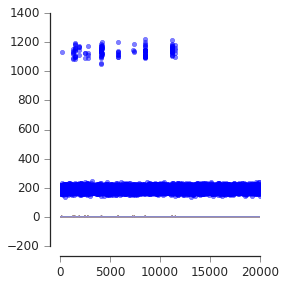

In [30]:
data1 = 'Wn_single3.h5'
emission_data = pd.HDFStore(data1)
fig = plt.figure(figsize=(4,4)) 
    
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(4000,5000,100):
    plt.plot(range(N),emission_data['df{}'.format(i)].iloc[0]) 
plt.scatter(range(N), Wn, color="blue", alpha=0.5)
plt.xlim([0,20000])
# plt.ylim([0,3000])
# plt.ylabel(ylabel)
# plt.xlabel(xlabel)
plt.tight_layout()
sns.despine(offset=10)
# fig.savefig('Emission_distribution.pdf')

In [ ]:
step = 0.01
partitions = [i*step for i in range(round(200./step))]
t = partitions

In [ ]:
plt.step(x=t[:-1],y=Sn[0,:], color="blue") 

In [ ]:
np.shape(Sn_true[0,:])

In [ ]:
np.shape(t[:-1])

In [ ]:
Sn_true = pd.read_csv('trajectory_single_particle.csv').drop('Unnamed: 0',axis=1).values

data3 = 'trajectory_single.h5'
traj = pd.HDFStore(data3)
fig = plt.figure(figsize=(4,4)) 
    
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(100,5000,100):
    plt.step(x=t[:-1],y=traj['df{}'.format(i)].iloc[0],color='red') 
plt.step(x=t[:-1],y=Sn_true[0,:], color="blue") 

In [ ]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

In [ ]:
h = sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)
h.ax_joint.set_ylim([0,25])

In [ ]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =20,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
sns_plot.ax_joint.set_ylim([0,2000])
# sns_plot.savefig('Emission_background.pdf')

In [ ]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s =20,linewidth=2)
# sns_plot.ax_joint.set_ylim([0,5000])
sns_plot.savefig('Photon_Emission.pdf')

In [ ]:
d = (scipy.special.kv(hyper_param['alfa']-hyper_param['alfa1_prior'],2*np.sqrt(np.linspace(1,40,1000))*(hyper_param['beta1']*hyper_param['beta2']))/
     np.linspace(1,40,1000)**(1-(hyper_param['alfa']+hyper_param['alfa1_prior'])/2))

In [ ]:
n, bins, patches = plt.hist(out[0]['E_b'], 50, facecolor='blue')
plt.plot(d*10000,color='k')
plt.xlim([0,40])
# plt.ylim([0,1])
# plt.axvline(1000, color='r')

In [ ]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+3, color='r')

In [ ]:
plt.step(x=t[:-1],y=Sn[0,:])

In [ ]:
out1 = out[2] 
pi_true = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
                    [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
                    [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
    fig.savefig('Probability_distribution.pdf')
    return None

In [ ]:
plot_hist(d, pi_true)